<a href="https://colab.research.google.com/github/krist2357/portafolio/blob/main/Estudio_canal_wifi_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ALTERNATIVAS PARA EL DISEÑO Y PLANIFICACIÓN DE REDES WIFI USANDO EL ALGORITMO KNN Y LSTM

## OBJETIVOS: 
La idea de este primer proyecto, es encontrar alternativas para planificar y diseñar las redes WIFi. En este sentido, en base al contenido de una base de datos de Kaggle, se pretende: 
* Clasificar un canal de comunicaciones en la banda de 2,4GHZ, usando KNN.
* Predecir la ocupación del canal 6 usando las redes LSTM.

# CARACTERÍSTICAS Y CARGA DEL CONJUNTO DE DATOS


En el presente dataset: https://www.kaggle.com/code/jmartindelasierra/office-occupancy-using-wifi-signals/script

Se presenta las capturas de la señal Wifi, para encontrar el mejor canal de las redes 802.11, de tal forma que pueda ser usado como un análisis previo a la implementación de una red wifi en un entorno de oficinas. Se comparará algunos de los algoritmos de Aprendizaje automatico y profundo para visualizar cual de todos clasifica mejor el canal.

EL dataset, muestra la captura de los siguientes valores:

SSID (nombre de la red)



*   MAC address (Identificador del interface de radio)
*   Vendor (Fabricante)
*   Signal strength (Potencia de la señal en dBm)
*   Channel (Identificador de frecuencia de la banda en uso).

Los valores, fueron obtenidos mediante el software: https://www.the-sz.com/products/homedale/, el mismo tiene la capacidad de guardar las muestras de los datos capturados por el interfaz Wifi del computador de prueba.

Se realizaron 9 surveys de los datos en una oficina, que presentan muestras de longitud variable.

** OJO: Las muestras se tomaron cada minuto**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colo
from matplotlib.ticker import NullFormatter
import seaborn as sns
import os

In [ ]:
mainpath = "/content/drive/My Drive/Colab Notebooks/TFM"
filename = "WIFI_DATA_OCCUPANCY/wifi_data.csv"
fullpath = os.path.join(mainpath, filename)

## Carga del conjunto de datos:

In [ ]:
data = pd.read_csv(fullpath, sep=';' ,encoding='ISO-8859-1') # Para este dataset, es necesario colocar la codificación.

## Resumen de la estructura del dataset

In [ ]:
data.head(10) # Se presentan los 10 primeros datos

,Time,MAC.Address,Vendor,SSID,Signal.Strength,Channel,Survey
0,2018-03-07 17:07:08,CC:D5:39:BA:75:20,Cisco Systems Inc.,WLAN_42,-72,1,1
1,2018-03-07 17:07:08,68:86:A7:CB:A9:01,Cisco Systems Inc.,CWLANGuest,-59,1,1
2,2018-03-07 17:07:08,68:86:A7:CB:A9:00,Cisco Systems Inc.,GUEST_TSI,-58,1,1
3,2018-03-07 17:07:08,2A:24:FF:74:F9:D8,Wistron Neweb Corporation,DIRECT-zV-BCNIMP017,-60,6,1
4,2018-03-07 17:07:08,2A:24:FF:79:D5:BC,Wistron Neweb Corporation,DIRECT-zV-BCNIMP016,-65,6,1
5,2018-03-07 17:07:08,DC:66:72:F8:BF:1F,Samsung Electronics Co. Ltd,AndroidAP6485,-58,8,1
6,2018-03-07 17:07:08,34:A8:4E:C6:0C:70,Cisco Systems Inc.,GUEST_TSI,-54,11,1
7,2018-03-07 17:07:08,34:A8:4E:C6:0C:71,Cisco Systems Inc.,CWLANGuest,-54,11,1
8,2018-03-07 17:07:08,1C:23:2C:D1:0F:41,Samsung Electronics Co. Ltd,AndroidAP2029,-67,4,1
9,2018-03-07 17:07:08,34:A8:4E:C6:27:61,Cisco Systems Inc.,CWLANGuest,-65,6,1


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 648192 entries, 0 to 648191
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Time             648192 non-null  object
 1   MAC.Address      648192 non-null  object
 2   Vendor           413900 non-null  object
 3   SSID             637099 non-null  object
 4   Signal.Strength  648192 non-null  int64 
 5   Channel          648192 non-null  int64 
 6   Survey           648192 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 34.6+ MB


In [ ]:
data.shape # Dimensión del dataset

(648192, 7)

In [ ]:
data.describe() #Estadísticos básicos

,Signal.Strength,Channel,Survey
count,648192.000000,648192.000000,648192.00000
mean,-62.413598,5.817276,5.33531
std,5.973211,4.204900,2.82867
min,-95.000000,1.000000,1.00000
25%,-67.000000,1.000000,2.00000
50%,-61.000000,6.000000,6.00000
75%,-58.000000,11.000000,7.00000
max,-10.000000,12.000000,9.00000


In [ ]:
data.dtypes

Time               object
MAC.Address        object
Vendor             object
SSID               object
Signal.Strength     int64
Channel             int64
Survey              int64
dtype: object

# ANALISIS DEL CONJUNTO DE DATOS

## Separación de los valores de Fecha y hora

In [ ]:
data['Dates'] = pd.to_datetime(data['Time']).dt.date
data['Times'] = pd.to_datetime(data['Time']).dt.time
data['Hours'] = pd.to_datetime(data['Time']).dt.hour
data=data.drop('Time', axis=1)
data.insert(0, 'Time', data['Times'])
data.insert(1, 'Hour', data['Hours'])
data.insert(2, 'Date', data['Dates'])
data=data.drop('Dates', axis=1)
data=data.drop('Times', axis=1)
data=data.drop('Hours', axis=1)

In [ ]:
# CAmbiamos las variables Time y Date a String, debido que al separar quedan con formato datetime
data['Time'] = data['Time'].astype(str) # Cambiar la variable Time a String
data['Date'] = data['Date'].astype(str) # Cambiar la variable Date a String
data['Hour'] = data['Hour'].astype(int) # Cambiar la variable Hour a String

In [ ]:
data.head(10)

,Time,Hour,Date,MAC.Address,Vendor,SSID,Signal.Strength,Channel,Survey
0,17:07:08,17,2018-03-07,CC:D5:39:BA:75:20,Cisco Systems Inc.,WLAN_42,-72,1,1
1,17:07:08,17,2018-03-07,68:86:A7:CB:A9:01,Cisco Systems Inc.,CWLANGuest,-59,1,1
2,17:07:08,17,2018-03-07,68:86:A7:CB:A9:00,Cisco Systems Inc.,GUEST_TSI,-58,1,1
3,17:07:08,17,2018-03-07,2A:24:FF:74:F9:D8,Wistron Neweb Corporation,DIRECT-zV-BCNIMP017,-60,6,1
4,17:07:08,17,2018-03-07,2A:24:FF:79:D5:BC,Wistron Neweb Corporation,DIRECT-zV-BCNIMP016,-65,6,1
5,17:07:08,17,2018-03-07,DC:66:72:F8:BF:1F,Samsung Electronics Co. Ltd,AndroidAP6485,-58,8,1
6,17:07:08,17,2018-03-07,34:A8:4E:C6:0C:70,Cisco Systems Inc.,GUEST_TSI,-54,11,1
7,17:07:08,17,2018-03-07,34:A8:4E:C6:0C:71,Cisco Systems Inc.,CWLANGuest,-54,11,1
8,17:07:08,17,2018-03-07,1C:23:2C:D1:0F:41,Samsung Electronics Co. Ltd,AndroidAP2029,-67,4,1
9,17:07:08,17,2018-03-07,34:A8:4E:C6:27:61,Cisco Systems Inc.,CWLANGuest,-65,6,1


## Datos faltantes

Se aprecia que faltan muchos datos en las variables del SSID y Vendor. Esto no sería un inconveniente ya que existe el campo MAC.Address para identificar el Punto de Acceso inalámbrico.

In [ ]:
data.isnull().sum()

Time                    0
Hour                    0
Date                    0
MAC.Address             0
Vendor             234292
SSID                11093
Signal.Strength         0
Channel                 0
Survey                  0
dtype: int64

## Reemplazo de valores faltantes

En este caso, se reemplaza los valores NA por la palabra oculto.
Se cambia de nombre al dataset. Esto, se considera debido a que los valores de SSID y VENDOR, fueron ocultados por temas de seguridad, o a su vez el punto de acceso está muy lejano.

In [ ]:
data = data.fillna("Oculto") #Reemplazo por el nombre oculto

In [ ]:
data.isnull().sum()

Time               0
Hour               0
Date               0
MAC.Address        0
Vendor             0
SSID               0
Signal.Strength    0
Channel            0
Survey             0
dtype: int64

## Cuenta de datos de las columnas



Se aprecia la cantidad de surveys realizados y las muestras tomadas en cada survey, las cuales son de longitud variable.

Se puede apreciar que la longitud de direcciones MAC, es mayor que los SSID, esto es debido a que un SSID puede ser repetido en varios puntos de accesos con el fín de realizar roaming entre puntos de acceso. Entonces una cantidad real de radios puede ser visualizada mediante la dirección MAC.

Tambien, se puede apreciar, que los puntos de acceso que están radiando en la oficina tienen el SSID: CWLANGuest y GUEST_TSI

Se aprecia también cual de los AP, está radiando con mas potencia, en este caso se observa que en el survey 9, un punto de acceso tiene -10dB de potencia. Pero las muestras distinguen 1 sola. con dicha potencia. 

### Columna Survey

In [ ]:
data['Survey'].value_counts() # Contar la cantidad de muestras realizadas en los 9 surveys

7    163978
2    130227
9    117209
1     68570
5     50333
6     36778
8     36525
4     28305
3     16267
Name: Survey, dtype: int64

### Columna MAC ADDRESS

In [ ]:
data['MAC.Address'].value_counts() # Cantidad de muestras de direcciones MAC

2A:24:FF:74:F9:D8    56602
2A:24:FF:79:D5:BC    56487
34:A8:4E:C6:0C:71    55566
34:A8:4E:C6:0C:70    55276
68:86:A7:CB:A9:01    49604
                     ...  
00:1B:2A:2F:C0:F0        1
58:44:98:26:9B:04        1
C0:EE:FB:4B:14:28        1
24:92:0E:06:F3:58        1
24:92:0E:16:AB:4E        1
Name: MAC.Address, Length: 119, dtype: int64

### Columna SSID

In [ ]:
data['SSID'].value_counts() # Cantidad de muestras de SSID

CWLANGuest             147620
GUEST_TSI              144222
DIRECT-zV-BCNIMP017     56602
DIRECT-zV-BCNIMP016     56487
WLAN_42                 44179
                        ...  
AndroidAP8850               1
Redmi 3S jfS                1
OjO                         1
CoBiNsKy Phone              1
AndroidAP3990               1
Name: SSID, Length: 95, dtype: int64

### Columna Intensidad de la señal

In [ ]:
data['Signal.Strength'].value_counts() # Niveles de señal detectados

-54    75829
-61    63889
-60    62681
-65    61685
-70    56924
-66    47805
-67    36733
-58    31207
-72    30679
-64    29093
-71    27468
-55    20656
-59    20551
-53    19505
-57    18879
-63    17481
-73    13265
-52    13148
-69      331
-74      172
-77      103
-51       62
-86       25
-49        7
-47        5
-45        4
-48        2
-50        1
-95        1
-10        1
Name: Signal.Strength, dtype: int64

### Eliminación de muestras con un nivel de señal que pueden considerarse anomalías

In [ ]:
# Se elimina del dataset las filas que tienen pocas muestras, se considera que no son relevantes para el análisis
data =  data[(data['Signal.Strength'] != -10) & 
             (data['Signal.Strength'] != -95) & 
             (data['Signal.Strength'] != -50) & 
             (data['Signal.Strength'] != -48) & 
             (data['Signal.Strength'] != -45) & 
             (data['Signal.Strength'] != -47) & 
             (data['Signal.Strength'] != -49)]

### Cuenta de intensidad de la señal sin anomalias

In [ ]:
data['Signal.Strength'].value_counts() # Niveles de señal detectados

-54    75829
-61    63889
-60    62681
-65    61685
-70    56924
-66    47805
-67    36733
-58    31207
-72    30679
-64    29093
-71    27468
-55    20656
-59    20551
-53    19505
-57    18879
-63    17481
-73    13265
-52    13148
-69      331
-74      172
-77      103
-51       62
-86       25
Name: Signal.Strength, dtype: int64

### Cuenta de número de canales

In [ ]:
data['Channel'].value_counts() # Canales Usados

1     239747
11    216514
6     184373
3       2741
9       1742
4        948
8        935
2        570
12       509
5         83
10         5
7          4
Name: Channel, dtype: int64

In [ ]:
data.sort_values('Signal.Strength', ascending = False).head(15) # Orden Descendente en el nivel de la señal.

,Time,Hour,Date,MAC.Address,Vendor,SSID,Signal.Strength,Channel,Survey
333969,13:46:45,13,2018-04-11,1C:23:2C:D1:0F:41,Oculto,AndroidAP2029,-51,3,7
64729,10:32:55,10,2018-03-12,34:A8:4E:C6:0C:70,Cisco Systems Inc.,GUEST_TSI,-51,11,1
314299,10:23:47,10,2018-04-04,DC:66:72:F8:BF:1F,Samsung Electronics Co. Ltd,AndroidAP6485,-51,11,6
244967,10:30:13,10,2018-03-23,DC:66:72:F8:BF:1F,Oculto,AndroidAP6485,-51,9,5
108658,15:40:56,15,2018-03-15,DC:66:72:F8:BF:1F,Samsung Electronics Co. Ltd,AndroidAP6485,-51,9,2
244658,10:01:51,10,2018-03-23,DC:66:72:F8:BF:1F,Oculto,AndroidAP6485,-51,9,5
244983,10:31:14,10,2018-03-23,DC:66:72:F8:BF:1F,Oculto,AndroidAP6485,-51,9,5
249622,17:15:32,17,2018-03-23,DC:66:72:F8:BF:1F,Oculto,AndroidAP6485,-51,9,5
314342,10:26:50,10,2018-04-04,DC:66:72:F8:BF:1F,Samsung Electronics Co. Ltd,AndroidAP6485,-51,11,6
314050,10:06:33,10,2018-04-04,DC:66:72:F8:BF:1F,Samsung Electronics Co. Ltd,AndroidAP6485,-51,11,6


## Representación gráfica de los datos

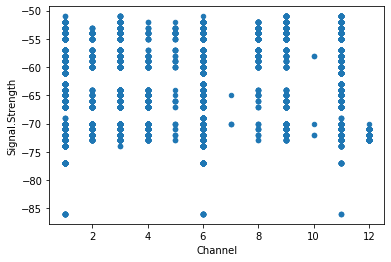

In [ ]:
# GRaficos de el canal versus la intensidad de la señal
data.plot(kind="scatter", y="Signal.Strength", x ="Channel")

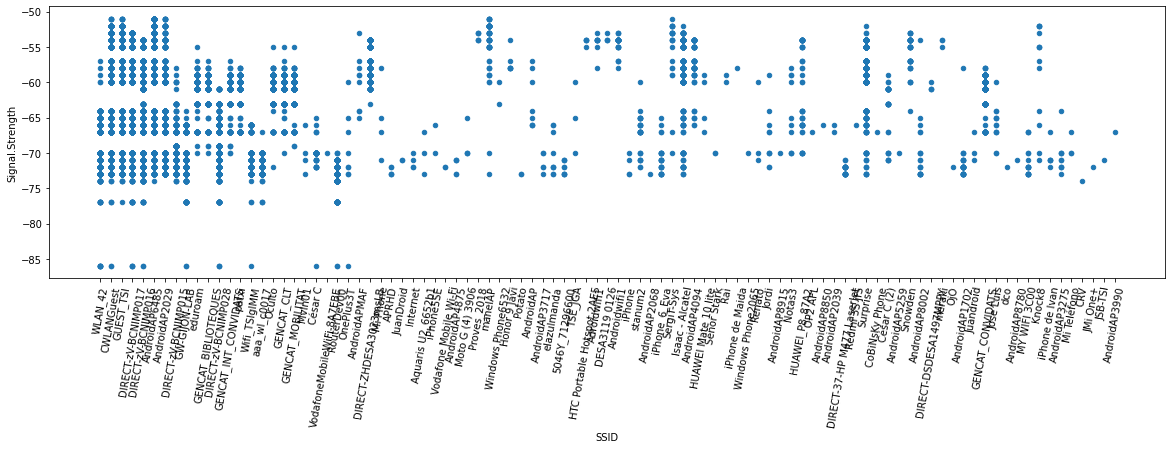

In [ ]:
# Gráfico de la intensidad de la señal versis SSID
data.plot(kind="scatter", y="Signal.Strength", x ="SSID", figsize = (20,5), rot=80)

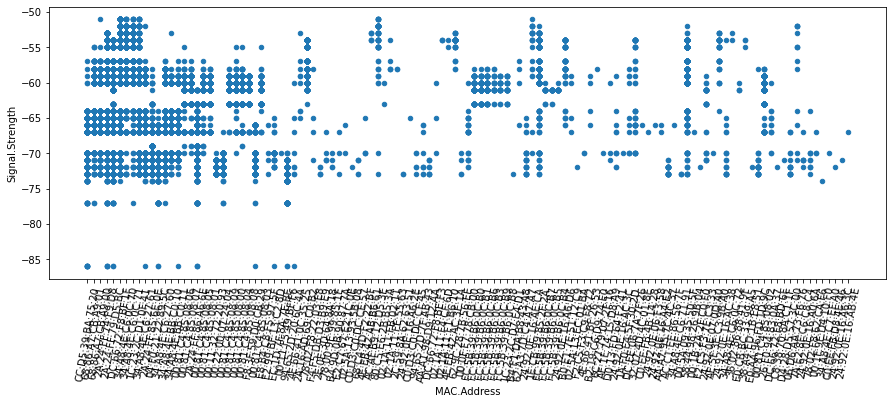

In [ ]:
# Gráfico de la intensidad de la señal versus la MAc Address
data.plot(kind="scatter", y="Signal.Strength", x ="MAC.Address",  figsize = (15,5), rot=80)

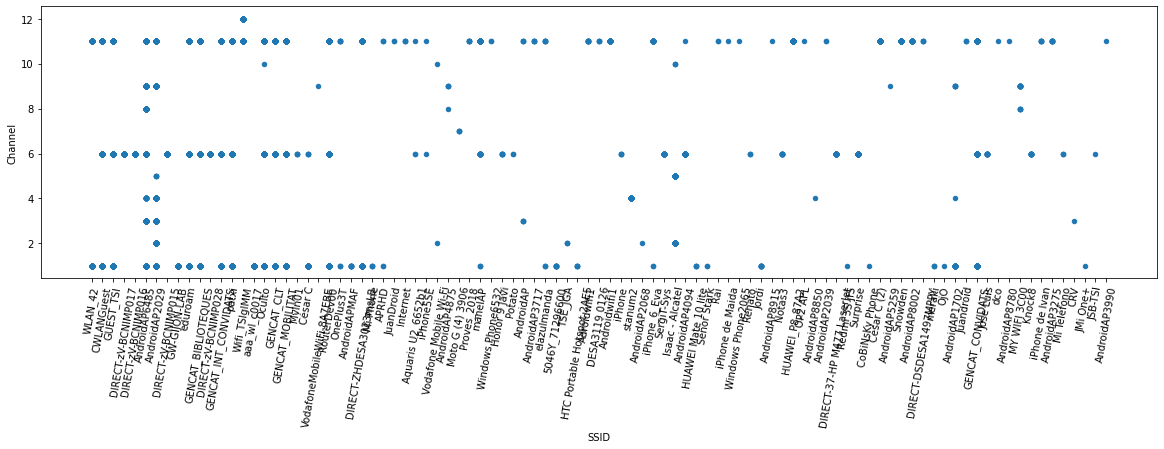

In [ ]:
# Gráfico del canal versus la MAc Address
data.plot(kind="scatter", y="Channel", x ="SSID", figsize = (20,5), rot=80)

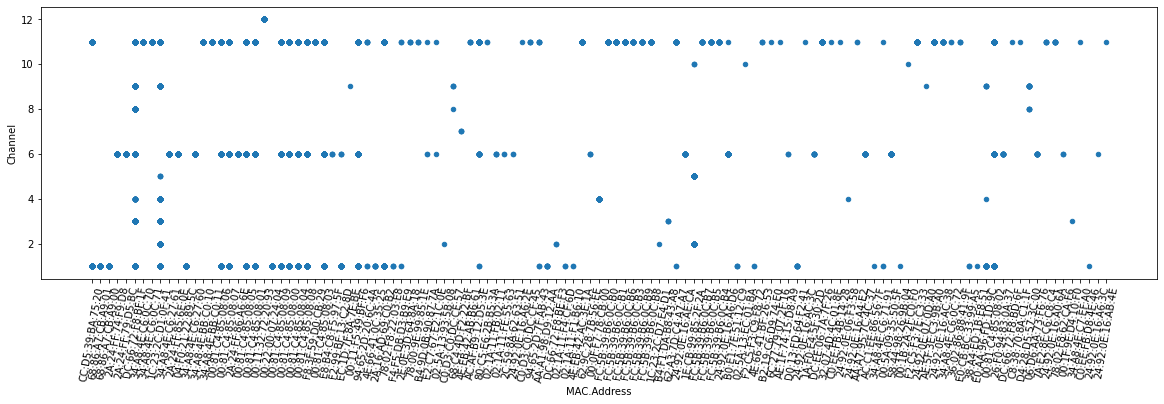

In [ ]:
# Gráfico del canal versus la Mac Address
data.plot(kind="scatter", y="Channel", x ="MAC.Address",  figsize = (20,5), rot=80)

## Tiempo de ocupación del canal en 2.4 GHz

### Cuenta del numero de muestras por día

In [ ]:
# Cantidad de muestras por día
data['Date'].value_counts() # Fechas de mayor Uso

2018-04-15    22720
2018-04-14    22438
2018-03-18    20922
2018-03-17    20840
2018-03-15    18982
2018-03-16    18889
2018-04-04    18378
2018-04-13    18092
2018-03-14    17717
2018-04-16    17572
2018-03-19    17569
2018-03-25    17278
2018-04-12    17083
2018-03-24    16553
2018-03-21    16424
2018-03-22    15519
2018-05-03    15425
2018-03-20    15391
2018-04-18    15288
2018-04-19    15162
2018-05-05    15148
2018-05-09    14939
2018-04-17    14934
2018-05-04    14748
2018-05-08    14391
2018-03-09    14264
2018-03-08    14017
2018-05-07    13982
2018-03-23    13500
2018-03-10    13418
2018-05-06    13263
2018-04-24    13195
2018-03-11    13190
2018-04-25    12864
2018-04-03    12681
2018-04-11    11209
2018-03-13    10014
2018-05-02     9579
2018-03-12     9496
2018-04-20     9478
2018-04-23     8824
2018-05-10     5728
2018-04-05     5718
2018-03-26     5524
2018-03-07     4183
2018-04-26     1642
Name: Date, dtype: int64

### Cuenta del número de muestras por hora

In [ ]:
# Cantidad de muestras de horas
data['Time'].value_counts()# Hora de mayor uso

19:16:34    72
03:42:04    71
15:17:20    67
19:22:39    67
12:18:54    63
            ..
06:39:27     1
18:59:49     1
19:58:36     1
17:56:44     1
07:03:26     1
Name: Time, Length: 42767, dtype: int64

### Graficos del tiempo de ocupación

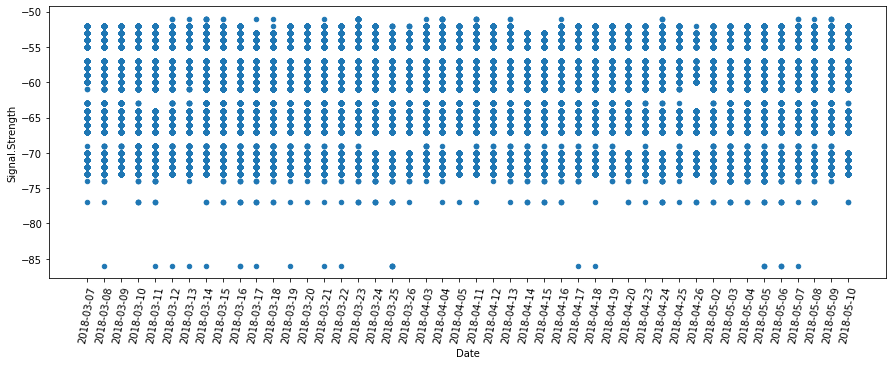

In [ ]:
# Gráfico de la intensidad de la señal versus el día (TIEMPO DE OCUPACIÓN POR DÍA)
data.plot(kind="scatter", y="Signal.Strength", x ="Date",  figsize = (15,5), rot=80)

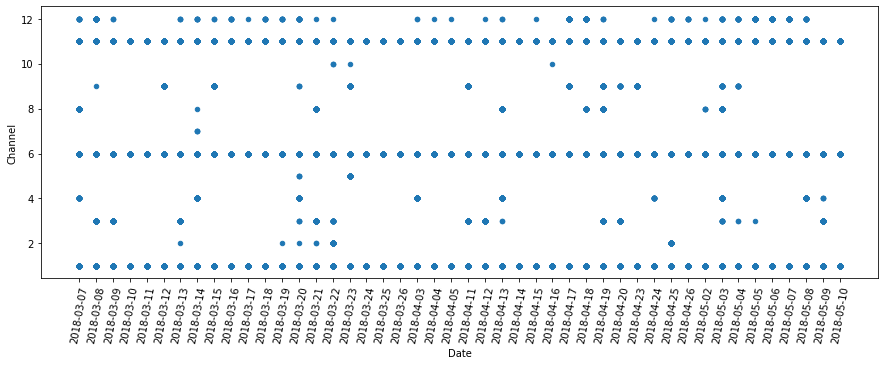

In [ ]:
# Gráfico del canal versus el día (TIEMPO DE OCUPACIÓN DEL CANAL EN DÍAS)
data.plot(kind="scatter", y="Channel", x ="Date",  figsize = (15,5), rot=80)

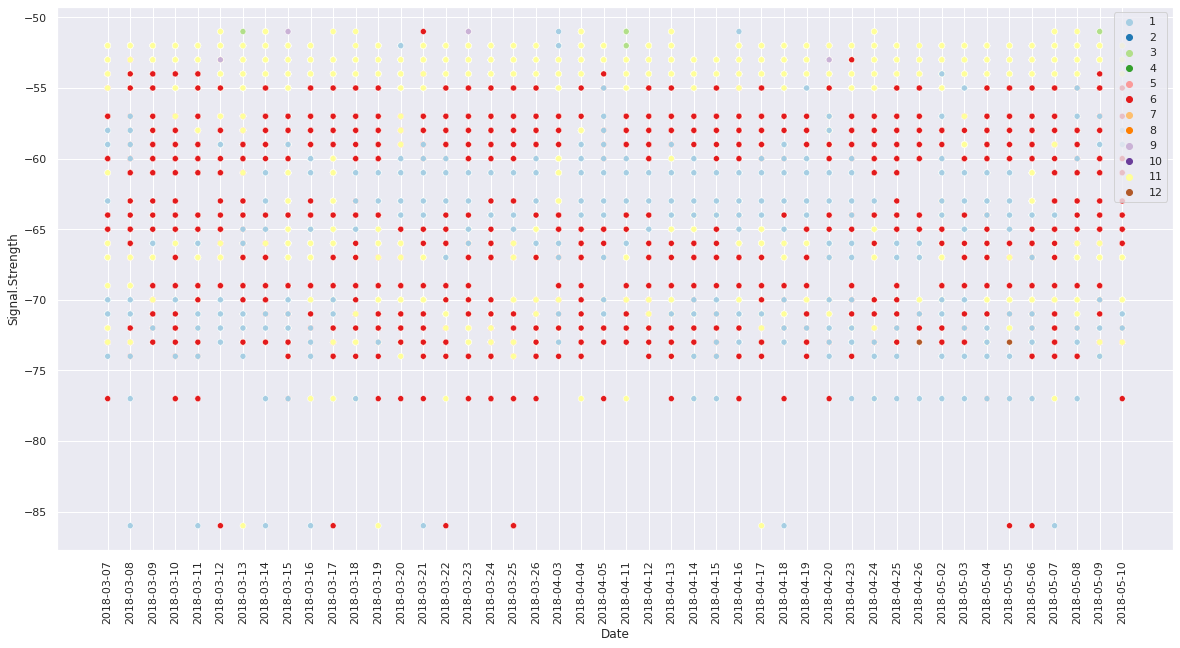

In [ ]:
# Gráfico del Intensidad de la señal versus el día (TIEMPO DE OCUPACIÓN DEL CANAL EN DÍAS)
sns.set(rc={"figure.figsize":(20, 10)})
g = sns.scatterplot(x='Date', y='Signal.Strength', hue='Channel', data=data, palette='Paired')
g.tick_params(axis='x', rotation=90)
plt.legend(loc='upper right')

### Agrupación por canal y Tiempo e RSSI máx y min 

In [ ]:
# Tabla con datos agrupados de canal y min y max de horas y nivel de intensidad de señal.
data1 = data.groupby(['Channel']).agg({'Time':[min,max], 'Signal.Strength':[min,max]})
data1

Time           Signal.Strength    
              min       max             min max
Channel                                        
1        00:00:00  23:59:59             -86 -51
2        09:10:04  19:47:13             -73 -53
3        01:41:20  21:18:54             -74 -51
4        09:06:33  18:06:36             -73 -52
5        09:15:06  12:58:10             -73 -52
6        00:00:00  23:59:59             -86 -51
7        13:44:57  13:49:01             -70 -65
8        08:57:25  18:45:12             -73 -52
9        08:58:12  19:38:49             -73 -51
10       09:13:13  17:54:40             -72 -58
11       00:00:00  23:59:59             -86 -51
12       00:01:30  23:56:26             -73 -70

### Agrupación por canal y cuenta de SSID y MAC

In [ ]:
# Agrupación por canal min-max de horas y nivel de señal y cantidad de muestras de SSID y MAC
data3 = data.groupby(['Channel']).agg({'Time':[min,max], 'Signal.Strength':[min,max], 'SSID': 'count', 'MAC.Address': 'count'})
data3

Time           Signal.Strength        SSID MAC.Address
              min       max             min max   count       count
Channel                                                            
1        00:00:00  23:59:59             -86 -51  239747      239747
2        09:10:04  19:47:13             -73 -53     570         570
3        01:41:20  21:18:54             -74 -51    2741        2741
4        09:06:33  18:06:36             -73 -52     948         948
5        09:15:06  12:58:10             -73 -52      83          83
6        00:00:00  23:59:59             -86 -51  184373      184373
7        13:44:57  13:49:01             -70 -65       4           4
8        08:57:25  18:45:12             -73 -52     935         935
9        08:58:12  19:38:49             -73 -51    1742        1742
10       09:13:13  17:54:40             -72 -58       5           5
11       00:00:00  23:59:59             -86 -51  216514      216514
12       00:01:30  23:56:26             -73 -70     509         509

## Agrupación en un día especifico: 2018-03-08



In [ ]:
data4 = data[data['Date']=='2018-03-08']
data4

,Time,Hour,Date,MAC.Address,Vendor,SSID,Signal.Strength,Channel,Survey
4183,00:00:29,0,2018-03-08,68:86:A7:CB:A9:00,Cisco Systems Inc.,GUEST_TSI,-59,1,1
4184,00:00:29,0,2018-03-08,04:F0:21:22:89:5C,Compex Systems Pte Ltd,GW-GIJON-LAB,-70,1,1
4185,00:00:29,0,2018-03-08,CC:D5:39:BA:75:20,Cisco Systems Inc.,WLAN_42,-70,1,1
4186,00:00:29,0,2018-03-08,68:86:A7:CB:A9:01,Cisco Systems Inc.,CWLANGuest,-59,1,1
4187,00:00:29,0,2018-03-08,2A:24:FF:74:F9:D8,Wistron Neweb Corporation,DIRECT-zV-BCNIMP017,-57,6,1
...,...,...,...,...,...,...,...,...,...
18196,23:59:25,23,2018-03-08,34:A8:4E:C6:0C:70,Cisco Systems Inc.,GUEST_TSI,-52,11,1
18197,23:59:25,23,2018-03-08,34:A8:4E:C6:0C:71,Cisco Systems Inc.,CWLANGuest,-53,11,1
18198,23:59:25,23,2018-03-08,34:A8:4E:BB:C0:10,Cisco Systems Inc.,GUEST_TSI,-67,11,1
18199,23:59:25,23,2018-03-08,34:A8:4E:BB:C0:11,Cisco Systems Inc.,CWLANGuest,-67,11,1


## Agrupación por fecha, hora y canal para contar SSID: 2018-03-08

In [ ]:
# Agrupar por fecha, hora y canal contar SSID
data5 = data4.groupby(['Date', 'Time', 'Channel']).agg({'SSID' : 'count'})
data5.head(20)

SSID
Date       Time     Channel      
2018-03-08 00:00:29 1           4
                    6           2
                    11          4
           00:01:30 1           4
                    6           2
                    11          3
           00:02:31 1           4
                    6           2
                    11          5
           00:03:31 1           4
                    6           4
                    11          5
           00:04:32 1           4
                    6           3
                    11          4
           00:05:33 1           4
                    6           3
                    11          4
           00:06:34 1           4
                    6           3

## Agrupación por Fecha, hora y SSID para contar canal: 2018-03-08

In [ ]:
# Agrupar por SSID contar canal
data6 = data4.groupby(['Date', 'Time','SSID']).agg({'Channel' : 'count'})
data6.head(10)

Channel
Date       Time     SSID                        
2018-03-08 00:00:29 CWLANGuest                 3
                    DIRECT-zV-BCNIMP016        1
                    DIRECT-zV-BCNIMP017        1
                    GUEST_TSI                  3
                    GW-GIJON-LAB               1
                    WLAN_42                    1
           00:01:30 CWLANGuest                 2
                    DIRECT-zV-BCNIMP016        1
                    DIRECT-zV-BCNIMP017        1
                    GUEST_TSI                  3

## Agrupar por Día, hora y canal para ver el nivel de señal: 2018-03-08.

In [ ]:
# Agrupar por Día, hora y canal para ver el nivel de señal
data7 = data4.groupby(['Date', 'Hour','Channel']).agg({'Signal.Strength' : 'mean'})
data7.head(5)

Signal.Strength
Date       Hour Channel                 
2018-03-08 0    1             -64.135021
                6             -62.452830
                11            -60.415179
                12            -72.888889
           1    1             -64.408333

## Gráfico del Nivel de señal versus el tiempo en horas de un día específico: 2018-03-08.

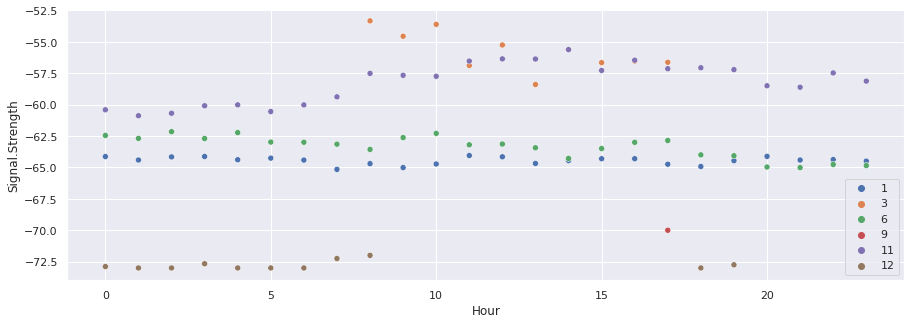

In [ ]:
# Gráfico del canal versus un Día (Horas) (TIEMPO DE OCUPACIÓN DEL CANAL EN UN DÍA)
sns.set(rc={"figure.figsize":(15, 5)})
g = sns.scatterplot(x='Hour', y='Signal.Strength', hue='Channel', data=data7, palette="deep")
g.tick_params(axis='x', rotation=0)
plt.legend(loc='lower right')

# ANÁLISIS SIN LOS PUNTOS DE DATOS DE LA OFICINA

In [ ]:
# Filtro los AP que pertenecen a la oficina para analizar el medio de transmisión respectivo.
noap1 = data['SSID'] != 'GUEST_TSI'
noap2 = data['SSID'] != 'CWLANGuest'

# Elimino los AP anteriormente filtrados
df_oap = data[noap1 & noap2]

df_oap.head(10)

,Time,Hour,Date,MAC.Address,Vendor,SSID,Signal.Strength,Channel,Survey
0,17:07:08,17,2018-03-07,CC:D5:39:BA:75:20,Cisco Systems Inc.,WLAN_42,-72,1,1
3,17:07:08,17,2018-03-07,2A:24:FF:74:F9:D8,Wistron Neweb Corporation,DIRECT-zV-BCNIMP017,-60,6,1
4,17:07:08,17,2018-03-07,2A:24:FF:79:D5:BC,Wistron Neweb Corporation,DIRECT-zV-BCNIMP016,-65,6,1
5,17:07:08,17,2018-03-07,DC:66:72:F8:BF:1F,Samsung Electronics Co. Ltd,AndroidAP6485,-58,8,1
8,17:07:08,17,2018-03-07,1C:23:2C:D1:0F:41,Samsung Electronics Co. Ltd,AndroidAP2029,-67,4,1
10,17:08:08,17,2018-03-07,CC:D5:39:BA:75:20,Cisco Systems Inc.,WLAN_42,-64,1,1
13,17:08:08,17,2018-03-07,2A:24:FF:74:F9:D8,Wistron Neweb Corporation,DIRECT-zV-BCNIMP017,-67,6,1
14,17:08:08,17,2018-03-07,DC:66:72:F8:BF:1F,Samsung Electronics Co. Ltd,AndroidAP6485,-53,8,1
15,17:08:08,17,2018-03-07,2A:24:FF:79:D5:BC,Wistron Neweb Corporation,DIRECT-zV-BCNIMP016,-70,6,1
18,17:08:08,17,2018-03-07,2A:24:FF:85:6E:0E,Wistron Neweb Corporation,DIRECT-zV-BCNIMP015,-72,6,1


In [ ]:
df_oap.shape

(356337, 9)

### Filtrando en un día

In [ ]:
df_oap1 = df_oap[df_oap['Date']=='2018-03-08']
df_oap1

,Time,Hour,Date,MAC.Address,Vendor,SSID,Signal.Strength,Channel,Survey
4184,00:00:29,0,2018-03-08,04:F0:21:22:89:5C,Compex Systems Pte Ltd,GW-GIJON-LAB,-70,1,1
4185,00:00:29,0,2018-03-08,CC:D5:39:BA:75:20,Cisco Systems Inc.,WLAN_42,-70,1,1
4187,00:00:29,0,2018-03-08,2A:24:FF:74:F9:D8,Wistron Neweb Corporation,DIRECT-zV-BCNIMP017,-57,6,1
4188,00:00:29,0,2018-03-08,2A:24:FF:79:D5:BC,Wistron Neweb Corporation,DIRECT-zV-BCNIMP016,-60,6,1
4194,00:01:30,0,2018-03-08,04:F0:21:22:89:5C,Compex Systems Pte Ltd,GW-GIJON-LAB,-71,1,1
...,...,...,...,...,...,...,...,...,...
18190,23:59:25,23,2018-03-08,04:F0:21:22:89:5C,Compex Systems Pte Ltd,GW-GIJON-LAB,-70,1,1
18193,23:59:25,23,2018-03-08,CC:D5:39:BA:75:20,Cisco Systems Inc.,WLAN_42,-70,1,1
18194,23:59:25,23,2018-03-08,2A:24:FF:74:F9:D8,Wistron Neweb Corporation,DIRECT-zV-BCNIMP017,-54,6,1
18195,23:59:25,23,2018-03-08,2A:24:FF:79:D5:BC,Wistron Neweb Corporation,DIRECT-zV-BCNIMP016,-67,6,1


### Agrupando por Fecha, hora y canal contar SSID

In [ ]:
# Agrupar por Fecha hora y canal para contar SSID
df_oap2 = df_oap1.groupby(['Date', 'Time', 'Channel']).agg({'SSID' : 'count'}).reset_index()
df_oap2.head(10)

,Date,Time,Channel,SSID
0,2018-03-08,00:00:29,1,2
1,2018-03-08,00:00:29,6,2
2,2018-03-08,00:01:30,1,2
3,2018-03-08,00:01:30,6,2
4,2018-03-08,00:02:31,1,2
5,2018-03-08,00:02:31,6,2
6,2018-03-08,00:02:31,11,1
7,2018-03-08,00:03:31,1,2
8,2018-03-08,00:03:31,6,3
9,2018-03-08,00:03:31,11,1


In [ ]:
#Cálculo de la cantidad mínima y máxima de SSID
df_oap2.agg({'SSID': [min, max]})

,SSID
min,1
max,6


In [ ]:
df_oap2['SSID'].value_counts()

2    1889
1     983
3     437
4      53
5       2
6       1
Name: SSID, dtype: int64

### Agrupar por fecha, hora y SSID y contar los canales

In [ ]:
# Agrupar por SSID contar canal
df_oap3 = df_oap1.groupby(['Date', 'Time', 'SSID']).agg({'Channel' : 'count'}).reset_index()
df_oap3.head(10)

,Date,Time,SSID,Channel
0,2018-03-08,00:00:29,DIRECT-zV-BCNIMP016,1
1,2018-03-08,00:00:29,DIRECT-zV-BCNIMP017,1
2,2018-03-08,00:00:29,GW-GIJON-LAB,1
3,2018-03-08,00:00:29,WLAN_42,1
4,2018-03-08,00:01:30,DIRECT-zV-BCNIMP016,1
5,2018-03-08,00:01:30,DIRECT-zV-BCNIMP017,1
6,2018-03-08,00:01:30,GW-GIJON-LAB,1
7,2018-03-08,00:01:30,WLAN_42,1
8,2018-03-08,00:02:31,DIRECT-zV-BCNIMP016,1
9,2018-03-08,00:02:31,DIRECT-zV-BCNIMP017,1


In [ ]:
#Cálculo de la cantidad mínima y máxima de Canales
df_oap3.agg({'Channel': [min, max]})

,Channel
min,1
max,2


In [ ]:
df_oap3['Channel'].value_counts() 

1    6290
2       5
Name: Channel, dtype: int64

# PREPARACION DE LOS DATOS

Para formar las variables de entrada y salida del sistema a entrenar se considera:


Variables de salida:

  * Canal con interferencia con alto nivel de señal
  * Canal con interferencia sin alto nivel de señal
  * Canal sin interferencia con alto nivel de señal
  * Canal sin interferencia con alto nivel de señal


Variables de entrada:
 
 * Interferencia en el canal: que corresponde a la cantidad de SSID presentes en el canal
 * Intensidad de señal capturada
 * El canal

Se elimina del análisis los puntos de acceso pertenecientes a la oficina, para revisar como se encuentra el medio de transmisión y en base a esto, ver que canal elegir.

In [ ]:
data.head(10)

,Time,Hour,Date,MAC.Address,Vendor,SSID,Signal.Strength,Channel,Survey
0,17:07:08,17,2018-03-07,CC:D5:39:BA:75:20,Cisco Systems Inc.,WLAN_42,-72,1,1
1,17:07:08,17,2018-03-07,68:86:A7:CB:A9:01,Cisco Systems Inc.,CWLANGuest,-59,1,1
2,17:07:08,17,2018-03-07,68:86:A7:CB:A9:00,Cisco Systems Inc.,GUEST_TSI,-58,1,1
3,17:07:08,17,2018-03-07,2A:24:FF:74:F9:D8,Wistron Neweb Corporation,DIRECT-zV-BCNIMP017,-60,6,1
4,17:07:08,17,2018-03-07,2A:24:FF:79:D5:BC,Wistron Neweb Corporation,DIRECT-zV-BCNIMP016,-65,6,1
5,17:07:08,17,2018-03-07,DC:66:72:F8:BF:1F,Samsung Electronics Co. Ltd,AndroidAP6485,-58,8,1
6,17:07:08,17,2018-03-07,34:A8:4E:C6:0C:70,Cisco Systems Inc.,GUEST_TSI,-54,11,1
7,17:07:08,17,2018-03-07,34:A8:4E:C6:0C:71,Cisco Systems Inc.,CWLANGuest,-54,11,1
8,17:07:08,17,2018-03-07,1C:23:2C:D1:0F:41,Samsung Electronics Co. Ltd,AndroidAP2029,-67,4,1
9,17:07:08,17,2018-03-07,34:A8:4E:C6:27:61,Cisco Systems Inc.,CWLANGuest,-65,6,1


In [ ]:
data.shape

(648171, 9)

## Eliminación de los AP de oficina

In [ ]:
# Filtro los AP que pertenecen a la oficina para analizar el medio de transmisión respectivo.
noap1 = data['SSID'] != 'GUEST_TSI'
noap2 = data['SSID'] != 'CWLANGuest'

# Elimino los AP anteriormente filtrados
data8 = data[noap1 & noap2]

data8.head(4800)

,Time,Hour,Date,MAC.Address,Vendor,SSID,Signal.Strength,Channel,Survey
0,17:07:08,17,2018-03-07,CC:D5:39:BA:75:20,Cisco Systems Inc.,WLAN_42,-72,1,1
3,17:07:08,17,2018-03-07,2A:24:FF:74:F9:D8,Wistron Neweb Corporation,DIRECT-zV-BCNIMP017,-60,6,1
4,17:07:08,17,2018-03-07,2A:24:FF:79:D5:BC,Wistron Neweb Corporation,DIRECT-zV-BCNIMP016,-65,6,1
5,17:07:08,17,2018-03-07,DC:66:72:F8:BF:1F,Samsung Electronics Co. Ltd,AndroidAP6485,-58,8,1
8,17:07:08,17,2018-03-07,1C:23:2C:D1:0F:41,Samsung Electronics Co. Ltd,AndroidAP2029,-67,4,1
...,...,...,...,...,...,...,...,...,...
11311,11:56:55,11,2018-03-08,2A:24:FF:79:D5:BC,Wistron Neweb Corporation,DIRECT-zV-BCNIMP016,-66,6,1
11316,11:57:55,11,2018-03-08,04:F0:21:22:89:5C,Compex Systems Pte Ltd,GW-GIJON-LAB,-70,1,1
11317,11:57:55,11,2018-03-08,DC:66:72:F8:BF:1F,Samsung Electronics Co. Ltd,AndroidAP6485,-53,3,1
11318,11:57:55,11,2018-03-08,2A:24:FF:79:D5:BC,Wistron Neweb Corporation,DIRECT-zV-BCNIMP016,-59,6,1


In [ ]:
data8.shape

(356337, 9)

## Agrupación del dia, hora y canal para contar el número de SSID diferentes por canal.

In [ ]:
## Cálculo de la cantidad de SSID, se agrupan el dia y la hora, asi mismo se resetean los indices.
data9 = data8.groupby(['Date', 'Time', 'Channel']).agg({'SSID': 'count'}).reset_index()
data9.head(20)

,Date,Time,Channel,SSID
0,2018-03-07,17:07:08,1,1
1,2018-03-07,17:07:08,4,1
2,2018-03-07,17:07:08,6,2
3,2018-03-07,17:07:08,8,1
4,2018-03-07,17:08:08,1,1
5,2018-03-07,17:08:08,6,3
6,2018-03-07,17:08:08,8,1
7,2018-03-07,17:09:09,1,2
8,2018-03-07,17:09:09,4,1
9,2018-03-07,17:09:09,6,2


In [ ]:
data9.shape

(144407, 4)

In [ ]:
# Cambia de nombre a la variable, para representar la cantidad de SSID por canal
data10 = data9.set_axis(['Date', 'Time', 'Channel', 'N_SSID.channel'], axis=1)
data10.head(10)

,Date,Time,Channel,N_SSID.channel
0,2018-03-07,17:07:08,1,1
1,2018-03-07,17:07:08,4,1
2,2018-03-07,17:07:08,6,2
3,2018-03-07,17:07:08,8,1
4,2018-03-07,17:08:08,1,1
5,2018-03-07,17:08:08,6,3
6,2018-03-07,17:08:08,8,1
7,2018-03-07,17:09:09,1,2
8,2018-03-07,17:09:09,4,1
9,2018-03-07,17:09:09,6,2


In [ ]:
data10.shape

(144407, 4)

## Merge del dataset agrupado y el dataset sin los ap de oficina

In [ ]:
#Merge del data10 y el data8
data11 = pd.merge(left = data10, right = data8)
data11.head(20)

,Date,Time,Channel,N_SSID.channel,Hour,MAC.Address,Vendor,SSID,Signal.Strength,Survey
0,2018-03-07,17:07:08,1,1,17,CC:D5:39:BA:75:20,Cisco Systems Inc.,WLAN_42,-72,1
1,2018-03-07,17:07:08,4,1,17,1C:23:2C:D1:0F:41,Samsung Electronics Co. Ltd,AndroidAP2029,-67,1
2,2018-03-07,17:07:08,6,2,17,2A:24:FF:74:F9:D8,Wistron Neweb Corporation,DIRECT-zV-BCNIMP017,-60,1
3,2018-03-07,17:07:08,6,2,17,2A:24:FF:79:D5:BC,Wistron Neweb Corporation,DIRECT-zV-BCNIMP016,-65,1
4,2018-03-07,17:07:08,8,1,17,DC:66:72:F8:BF:1F,Samsung Electronics Co. Ltd,AndroidAP6485,-58,1
5,2018-03-07,17:08:08,1,1,17,CC:D5:39:BA:75:20,Cisco Systems Inc.,WLAN_42,-64,1
6,2018-03-07,17:08:08,6,3,17,2A:24:FF:74:F9:D8,Wistron Neweb Corporation,DIRECT-zV-BCNIMP017,-67,1
7,2018-03-07,17:08:08,6,3,17,2A:24:FF:79:D5:BC,Wistron Neweb Corporation,DIRECT-zV-BCNIMP016,-70,1
8,2018-03-07,17:08:08,6,3,17,2A:24:FF:85:6E:0E,Wistron Neweb Corporation,DIRECT-zV-BCNIMP015,-72,1
9,2018-03-07,17:08:08,8,1,17,DC:66:72:F8:BF:1F,Samsung Electronics Co. Ltd,AndroidAP6485,-53,1


In [ ]:
data11.shape

(356337, 10)

## Agrupar por día, hora y SSID, contar canales/ssid

In [ ]:
## Cálculo de la cantidad de canales por SSID, asi mismo se resetean los indices.
data12 = data8.groupby(['Date', 'Time', 'SSID']).agg({'Channel': 'count'}).reset_index()
data12.head(20)

,Date,Time,SSID,Channel
0,2018-03-07,17:07:08,AndroidAP2029,1
1,2018-03-07,17:07:08,AndroidAP6485,1
2,2018-03-07,17:07:08,DIRECT-zV-BCNIMP016,1
3,2018-03-07,17:07:08,DIRECT-zV-BCNIMP017,1
4,2018-03-07,17:07:08,WLAN_42,1
5,2018-03-07,17:08:08,AndroidAP6485,1
6,2018-03-07,17:08:08,DIRECT-zV-BCNIMP015,1
7,2018-03-07,17:08:08,DIRECT-zV-BCNIMP016,1
8,2018-03-07,17:08:08,DIRECT-zV-BCNIMP017,1
9,2018-03-07,17:08:08,WLAN_42,1


In [ ]:
data12.shape

(353739, 4)

In [ ]:
data13 = data12.set_axis(['Date', 'Time', 'SSID', 'N_Channel.ssid'], axis=1)
data13.head(10)

,Date,Time,SSID,N_Channel.ssid
0,2018-03-07,17:07:08,AndroidAP2029,1
1,2018-03-07,17:07:08,AndroidAP6485,1
2,2018-03-07,17:07:08,DIRECT-zV-BCNIMP016,1
3,2018-03-07,17:07:08,DIRECT-zV-BCNIMP017,1
4,2018-03-07,17:07:08,WLAN_42,1
5,2018-03-07,17:08:08,AndroidAP6485,1
6,2018-03-07,17:08:08,DIRECT-zV-BCNIMP015,1
7,2018-03-07,17:08:08,DIRECT-zV-BCNIMP016,1
8,2018-03-07,17:08:08,DIRECT-zV-BCNIMP017,1
9,2018-03-07,17:08:08,WLAN_42,1


## Merge del dataset agrupado y el dataset que se realizó el primer merge

In [ ]:
#Merge del dataset data11 y el dataset data13
data14 = pd.merge(left = data13, right = data11)
data14.head(10)

,Date,Time,SSID,N_Channel.ssid,Channel,N_SSID.channel,Hour,MAC.Address,Vendor,Signal.Strength,Survey
0,2018-03-07,17:07:08,AndroidAP2029,1,4,1,17,1C:23:2C:D1:0F:41,Samsung Electronics Co. Ltd,-67,1
1,2018-03-07,17:07:08,AndroidAP6485,1,8,1,17,DC:66:72:F8:BF:1F,Samsung Electronics Co. Ltd,-58,1
2,2018-03-07,17:07:08,DIRECT-zV-BCNIMP016,1,6,2,17,2A:24:FF:79:D5:BC,Wistron Neweb Corporation,-65,1
3,2018-03-07,17:07:08,DIRECT-zV-BCNIMP017,1,6,2,17,2A:24:FF:74:F9:D8,Wistron Neweb Corporation,-60,1
4,2018-03-07,17:07:08,WLAN_42,1,1,1,17,CC:D5:39:BA:75:20,Cisco Systems Inc.,-72,1
5,2018-03-07,17:08:08,AndroidAP6485,1,8,1,17,DC:66:72:F8:BF:1F,Samsung Electronics Co. Ltd,-53,1
6,2018-03-07,17:08:08,DIRECT-zV-BCNIMP015,1,6,3,17,2A:24:FF:85:6E:0E,Wistron Neweb Corporation,-72,1
7,2018-03-07,17:08:08,DIRECT-zV-BCNIMP016,1,6,3,17,2A:24:FF:79:D5:BC,Wistron Neweb Corporation,-70,1
8,2018-03-07,17:08:08,DIRECT-zV-BCNIMP017,1,6,3,17,2A:24:FF:74:F9:D8,Wistron Neweb Corporation,-67,1
9,2018-03-07,17:08:08,WLAN_42,1,1,1,17,CC:D5:39:BA:75:20,Cisco Systems Inc.,-64,1


In [ ]:
data14.shape

(356337, 11)

In [ ]:
#Ver si existen datos NaN (Valores no nulos)
data14.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356337 entries, 0 to 356336
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Date             356337 non-null  object
 1   Time             356337 non-null  object
 2   SSID             356337 non-null  object
 3   N_Channel.ssid   356337 non-null  int64 
 4   Channel          356337 non-null  int64 
 5   N_SSID.channel   356337 non-null  int64 
 6   Hour             356337 non-null  int64 
 7   MAC.Address      356337 non-null  object
 8   Vendor           356337 non-null  object
 9   Signal.Strength  356337 non-null  int64 
 10  Survey           356337 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 32.6+ MB


In [ ]:
# Eliminación de la columna vendor
data14 = data14.drop('Vendor', axis=1)
data14.head(2)

,Date,Time,SSID,N_Channel.ssid,Channel,N_SSID.channel,Hour,MAC.Address,Signal.Strength,Survey
0,2018-03-07,17:07:08,AndroidAP2029,1,4,1,17,1C:23:2C:D1:0F:41,-67,1
1,2018-03-07,17:07:08,AndroidAP6485,1,8,1,17,DC:66:72:F8:BF:1F,-58,1


## Correlacionando datos

In [ ]:
data14.corr()

,N_Channel.ssid,Channel,N_SSID.channel,Hour,Signal.Strength,Survey
N_Channel.ssid,1.000000,-0.008712,0.213596,-0.005332,0.047407,-0.014490
Channel,-0.008712,1.000000,-0.281639,0.002397,0.024263,-0.163975
N_SSID.channel,0.213596,-0.281639,1.000000,-0.034301,0.195014,-0.018369
Hour,-0.005332,0.002397,-0.034301,1.000000,0.015498,0.007525
Signal.Strength,0.047407,0.024263,0.195014,0.015498,1.000000,-0.001056
Survey,-0.014490,-0.163975,-0.018369,0.007525,-0.001056,1.000000


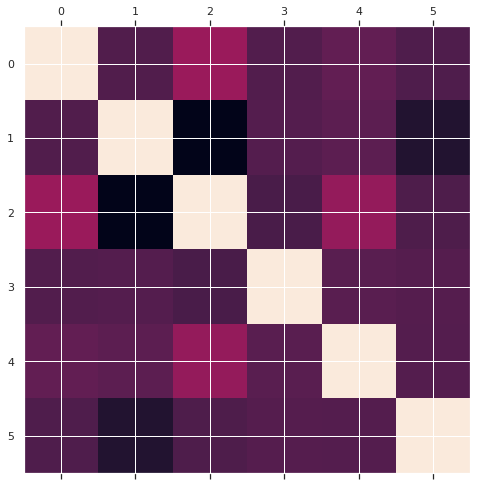

In [ ]:
plt.matshow(data14.corr())

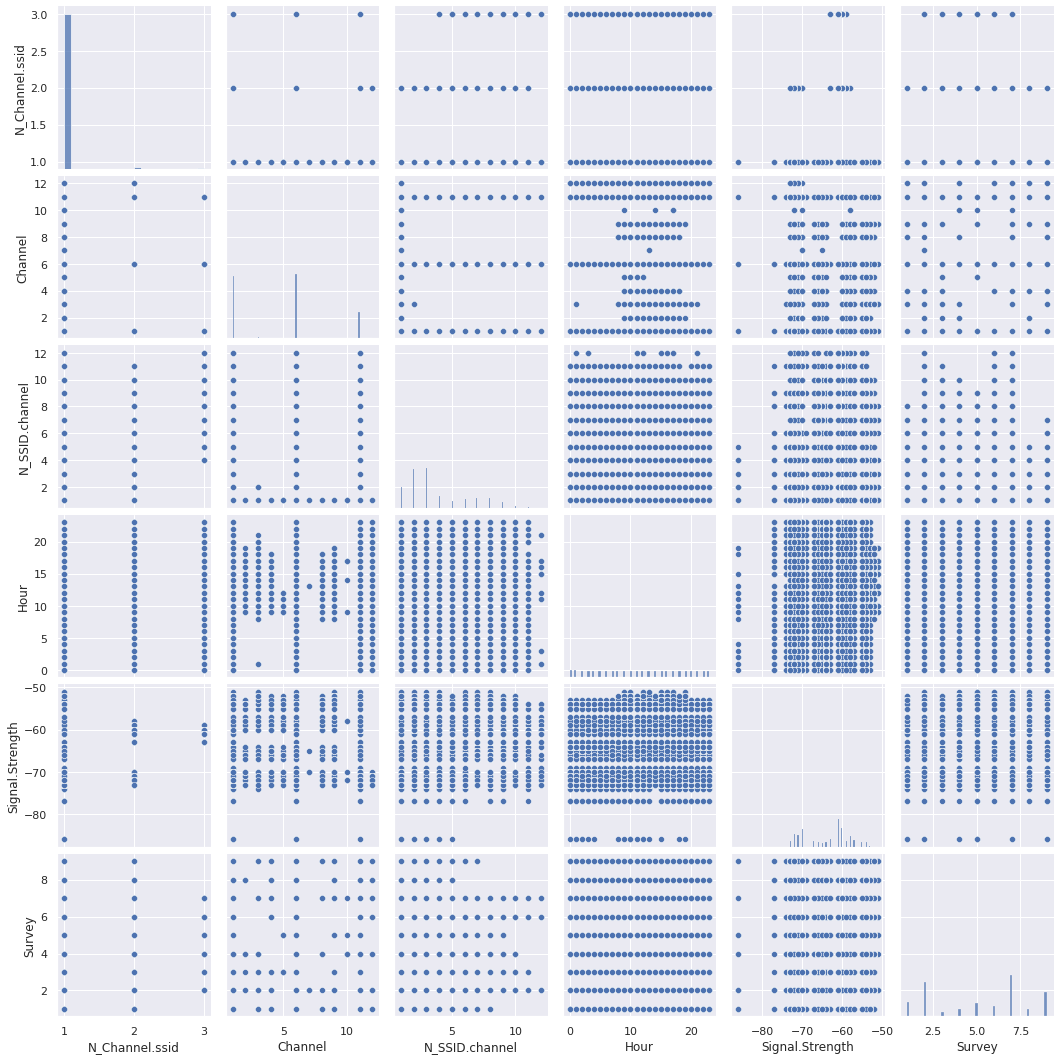

In [ ]:
sns.pairplot(data14)

In [ ]:
#Cálculo de la cantidad mínima y máxima de SSID
data14.agg({'N_SSID.channel': [min, max]})

,N_SSID.channel
min,1
max,12


In [ ]:
#Cálculo de la cantidad mínima y máxima de SSID
data14.agg({'N_Channel.ssid': [min, max]})

,N_Channel.ssid
min,1
max,3


## Análisis para construir un dataset para la clasificación y predicción de los datos.

Como  se ha mencionado, los datos corresponden a la captura por minuto de las señales WIFI de los puntos de acceso inalámbricos.

El este sentido, análisis corresponde a agrupar:

*  Diferentes SSID por canal en un minuto
*  Diferentes canales en un SSID en un minuto

De esta manera, se pretende ver, que variable usar para el modelo de clasificación y predicción.



In [ ]:
# Contar la cantidad de de SSID por canal
data14['N_SSID.channel'].value_counts()

3     91581
2     88254
1     48298
4     27076
8     22624
7     22484
6     21216
5     15015
9     13158
10     4850
11     1529
12      252
Name: N_SSID.channel, dtype: int64

In [ ]:
# Cantidad de canales usados por SSID
data14['N_Channel.ssid'].value_counts()

1    351492
2      3792
3      1053
Name: N_Channel.ssid, dtype: int64

## Grafico de la cantidad de SSID por canal y la RSSI en un día: 2018-03-08

Analizando la cantidad de canales presentes en día, se aprecia en la siguiente figura que solo hay el 1, el 3, el 6, el 9, el 11 y el 12.

Pero no están presentes el 2, 4, 5, 7, 8, 10, los cuales podrían usarse.

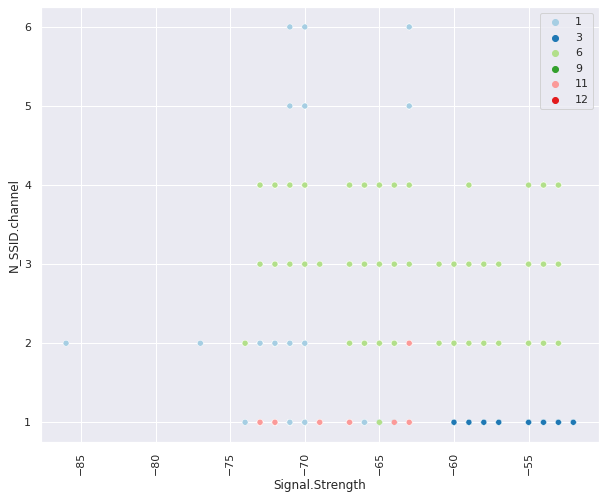

In [ ]:
# Gráfico de la cantidad de SSID vs la intensidad de la señal. y los segmentos de canales en un día
sns.set(rc={"figure.figsize":(10, 8)})
g = sns.scatterplot(x='Signal.Strength', y='N_SSID.channel', hue='Channel', data=data14[(data14['Date']=='2018-03-08')], palette='Paired')
g.tick_params(axis='x', rotation=90)
plt.legend(loc='upper right')

## Criterios para clasificación

La cantidad de SSID presentes en un canal de 2,4GHz, viene siendo un problema al momento de poner en producción las redes inalámbricas. En este sentido, loq ue se intenta es evitar la interferencia existente de los puntos de acceso.

En base al análisis de los problemas de cantidad de SSID/canal y nivel de señal en un día, se considera:

* Se establece el nivel de señal adecuado para cambiar de canal cuando exista señales mayores a los 75 dB.

* Se establece que la cantidad de SSID presentes en un canal no debe ser mayor a 1.

In [ ]:
#Creación de dos columnas de alto nivel de señal y alta cantidad de SSID
data14['High.SSID'] = 0
data14['High.Signal'] = 0
data14.head(5)

,Date,Time,SSID,N_Channel.ssid,Channel,N_SSID.channel,Hour,MAC.Address,Signal.Strength,Survey,High.SSID,High.Signal
0,2018-03-07,17:07:08,AndroidAP2029,1,4,1,17,1C:23:2C:D1:0F:41,-67,1,0,0
1,2018-03-07,17:07:08,AndroidAP6485,1,8,1,17,DC:66:72:F8:BF:1F,-58,1,0,0
2,2018-03-07,17:07:08,DIRECT-zV-BCNIMP016,1,6,2,17,2A:24:FF:79:D5:BC,-65,1,0,0
3,2018-03-07,17:07:08,DIRECT-zV-BCNIMP017,1,6,2,17,2A:24:FF:74:F9:D8,-60,1,0,0
4,2018-03-07,17:07:08,WLAN_42,1,1,1,17,CC:D5:39:BA:75:20,-72,1,0,0


In [ ]:
# función de determina el nivel de interferencia
def highSSID(value):
  if value > 1:
    return 1 # Si el número de AP es mayor a 1 colocar un 1
  else:
    return 0

In [ ]:
# función de determina el nivel bajo de potencia de señal.
def highSignal(value):
  if value > -75: 
    return 1 # Si el nivel de potencia es mayor a -75 dB colocar un 1
  else:
    return 0

In [ ]:
# Dataset con las columnas llenas con los valores de atenuacón e interferencia 1 es un valor alto, 0 es un valor bajo
data14['High.SSID'] = data14['N_SSID.channel'].apply(highSSID)
data14['High.Signal'] = data14['Signal.Strength'].apply(highSignal)
data14.head(10)

,Date,Time,SSID,N_Channel.ssid,Channel,N_SSID.channel,Hour,MAC.Address,Signal.Strength,Survey,High.SSID,High.Signal,Desicion.cambio
0,2018-03-07,17:07:08,AndroidAP2029,1,4,1,17,1C:23:2C:D1:0F:41,-67,1,0,1,3
1,2018-03-07,17:07:08,AndroidAP6485,1,8,1,17,DC:66:72:F8:BF:1F,-58,1,0,1,3
2,2018-03-07,17:07:08,DIRECT-zV-BCNIMP016,1,6,2,17,2A:24:FF:79:D5:BC,-65,1,1,1,3
3,2018-03-07,17:07:08,DIRECT-zV-BCNIMP017,1,6,2,17,2A:24:FF:74:F9:D8,-60,1,1,1,3
4,2018-03-07,17:07:08,WLAN_42,1,1,1,17,CC:D5:39:BA:75:20,-72,1,0,1,3
5,2018-03-07,17:08:08,AndroidAP6485,1,8,1,17,DC:66:72:F8:BF:1F,-53,1,0,1,3
6,2018-03-07,17:08:08,DIRECT-zV-BCNIMP015,1,6,3,17,2A:24:FF:85:6E:0E,-72,1,1,1,3
7,2018-03-07,17:08:08,DIRECT-zV-BCNIMP016,1,6,3,17,2A:24:FF:79:D5:BC,-70,1,1,1,3
8,2018-03-07,17:08:08,DIRECT-zV-BCNIMP017,1,6,3,17,2A:24:FF:74:F9:D8,-67,1,1,1,3
9,2018-03-07,17:08:08,WLAN_42,1,1,1,17,CC:D5:39:BA:75:20,-64,1,0,1,3


### Decisiones a tomar 

Finalmente se coloca la salida con las siguientes decisiones:

En este caso se clasificarán como 4 tipos de canales:

  * Canal sin muchos AP y sin altos niveles de señal presentes = 4 (Condición ideal, no cambiar de canal)
  * Canal sin muchos AP y con altos niveles de señal presentes = 3 (Cambiar a otro canal, porque puede haber otros canales sin altos niveles de señal presentes)
  * Canal con muchos AP y sin altos niveles de señal presentes = 2 (Aceptable, esperar)
  * Canal con muchos AP y con alto nivel de señal = 1 (cambiar de canal)

In [ ]:
# Se aumenta una columna de salida
data14['Desicion.cambio'] = 0
data14.head(5)

,Date,Time,SSID,N_Channel.ssid,Channel,N_SSID.channel,Hour,MAC.Address,Signal.Strength,Survey,High.SSID,High.Signal,Desicion.cambio
0,2018-03-07,17:07:08,AndroidAP2029,1,4,1,17,1C:23:2C:D1:0F:41,-67,1,1,1,0
1,2018-03-07,17:07:08,AndroidAP6485,1,8,1,17,DC:66:72:F8:BF:1F,-58,1,1,1,0
2,2018-03-07,17:07:08,DIRECT-zV-BCNIMP016,1,6,2,17,2A:24:FF:79:D5:BC,-65,1,1,1,0
3,2018-03-07,17:07:08,DIRECT-zV-BCNIMP017,1,6,2,17,2A:24:FF:74:F9:D8,-60,1,1,1,0
4,2018-03-07,17:07:08,WLAN_42,1,1,1,17,CC:D5:39:BA:75:20,-72,1,1,1,0


In [ ]:
# Función de salida para la desición de no cambiar de canal, esperar o cambio definitivo del canal.
def salida(d):
  if d[10] == 0 and d[11] == 0 :
    return 4
  elif d[10] == 0 and d[11] == 1:
    return 3
  elif d[10] == 1 and d[11] == 0:
    return 2
  else:
    return 1

In [ ]:
data14['Desicion.cambio'] = data14.apply(salida, axis=1)
data14.head(5)

,Date,Time,SSID,N_Channel.ssid,Channel,N_SSID.channel,Hour,MAC.Address,Signal.Strength,Survey,High.SSID,High.Signal,Desicion.cambio
0,2018-03-07,17:07:08,AndroidAP2029,1,4,1,17,1C:23:2C:D1:0F:41,-67,1,0,1,3
1,2018-03-07,17:07:08,AndroidAP6485,1,8,1,17,DC:66:72:F8:BF:1F,-58,1,0,1,3
2,2018-03-07,17:07:08,DIRECT-zV-BCNIMP016,1,6,2,17,2A:24:FF:79:D5:BC,-65,1,1,1,1
3,2018-03-07,17:07:08,DIRECT-zV-BCNIMP017,1,6,2,17,2A:24:FF:74:F9:D8,-60,1,1,1,1
4,2018-03-07,17:07:08,WLAN_42,1,1,1,17,CC:D5:39:BA:75:20,-72,1,0,1,3


In [ ]:
data14['Desicion.cambio'].value_counts()

1    307933
3     48282
2       106
4        16
Name: Desicion.cambio, dtype: int64

# CREACIÓN Y CARGA DEL DATASET FINAL

In [ ]:
# Guardar archivo en disco para usos futuros
mainpath = "/content/drive/My Drive/Colab Notebooks/TFM"
filename = "WIFI_DATA_OCCUPANCY/wifi_fit.csv"
fullpath = os.path.join(mainpath, filename)
data14.to_csv(fullpath, sep=';' ,encoding='ISO-8859-1') # Para este dataset, es necesario colocar la codificación.

NameError: ignored

## Carga del dataset final

In [ ]:
# Comprobar el dataset
mainpath = "/content/drive/My Drive/Colab Notebooks/TFM"
filename = "WIFI_DATA_OCCUPANCY/wifi_fit.csv"
fullpath = os.path.join(mainpath, filename)
df = pd.read_csv(fullpath, sep=';' ,encoding='ISO-8859-1') # Para este dataset, es necesario colocar la codificación.
df.head(10)

,Unnamed: 0,Date,Time,SSID,N_Channel.ssid,Channel,N_SSID.channel,Hour,MAC.Address,Signal.Strength,Survey,High.SSID,High.Signal,Desicion.cambio
0,0,2018-03-07,17:07:08,AndroidAP2029,1,4,1,17,1C:23:2C:D1:0F:41,-67,1,0,1,3
1,1,2018-03-07,17:07:08,AndroidAP6485,1,8,1,17,DC:66:72:F8:BF:1F,-58,1,0,1,3
2,2,2018-03-07,17:07:08,DIRECT-zV-BCNIMP016,1,6,2,17,2A:24:FF:79:D5:BC,-65,1,1,1,1
3,3,2018-03-07,17:07:08,DIRECT-zV-BCNIMP017,1,6,2,17,2A:24:FF:74:F9:D8,-60,1,1,1,1
4,4,2018-03-07,17:07:08,WLAN_42,1,1,1,17,CC:D5:39:BA:75:20,-72,1,0,1,3
5,5,2018-03-07,17:08:08,AndroidAP6485,1,8,1,17,DC:66:72:F8:BF:1F,-53,1,0,1,3
6,6,2018-03-07,17:08:08,DIRECT-zV-BCNIMP015,1,6,3,17,2A:24:FF:85:6E:0E,-72,1,1,1,1
7,7,2018-03-07,17:08:08,DIRECT-zV-BCNIMP016,1,6,3,17,2A:24:FF:79:D5:BC,-70,1,1,1,1
8,8,2018-03-07,17:08:08,DIRECT-zV-BCNIMP017,1,6,3,17,2A:24:FF:74:F9:D8,-67,1,1,1,1
9,9,2018-03-07,17:08:08,WLAN_42,1,1,1,17,CC:D5:39:BA:75:20,-64,1,0,1,3


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356337 entries, 0 to 356336
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Unnamed: 0       356337 non-null  int64 
 1   Date             356337 non-null  object
 2   Time             356337 non-null  object
 3   SSID             356337 non-null  object
 4   N_Channel.ssid   356337 non-null  int64 
 5   Channel          356337 non-null  int64 
 6   N_SSID.channel   356337 non-null  int64 
 7   Hour             356337 non-null  int64 
 8   MAC.Address      356337 non-null  object
 9   Signal.Strength  356337 non-null  int64 
 10  Survey           356337 non-null  int64 
 11  High.SSID        356337 non-null  int64 
 12  High.Signal      356337 non-null  int64 
 13  Desicion.cambio  356337 non-null  int64 
dtypes: int64(10), object(4)
memory usage: 38.1+ MB


In [ ]:
df = df.drop('Unnamed: 0', axis = 1)

In [ ]:
df.head(10)

,Date,Time,SSID,N_Channel.ssid,Channel,N_SSID.channel,Hour,MAC.Address,Signal.Strength,Survey,High.SSID,High.Signal,Desicion.cambio
0,2018-03-07,17:07:08,AndroidAP2029,1,4,1,17,1C:23:2C:D1:0F:41,-67,1,0,1,3
1,2018-03-07,17:07:08,AndroidAP6485,1,8,1,17,DC:66:72:F8:BF:1F,-58,1,0,1,3
2,2018-03-07,17:07:08,DIRECT-zV-BCNIMP016,1,6,2,17,2A:24:FF:79:D5:BC,-65,1,1,1,1
3,2018-03-07,17:07:08,DIRECT-zV-BCNIMP017,1,6,2,17,2A:24:FF:74:F9:D8,-60,1,1,1,1
4,2018-03-07,17:07:08,WLAN_42,1,1,1,17,CC:D5:39:BA:75:20,-72,1,0,1,3
5,2018-03-07,17:08:08,AndroidAP6485,1,8,1,17,DC:66:72:F8:BF:1F,-53,1,0,1,3
6,2018-03-07,17:08:08,DIRECT-zV-BCNIMP015,1,6,3,17,2A:24:FF:85:6E:0E,-72,1,1,1,1
7,2018-03-07,17:08:08,DIRECT-zV-BCNIMP016,1,6,3,17,2A:24:FF:79:D5:BC,-70,1,1,1,1
8,2018-03-07,17:08:08,DIRECT-zV-BCNIMP017,1,6,3,17,2A:24:FF:74:F9:D8,-67,1,1,1,1
9,2018-03-07,17:08:08,WLAN_42,1,1,1,17,CC:D5:39:BA:75:20,-64,1,0,1,3


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356337 entries, 0 to 356336
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Date             356337 non-null  object
 1   Time             356337 non-null  object
 2   SSID             356337 non-null  object
 3   N_Channel.ssid   356337 non-null  int64 
 4   Channel          356337 non-null  int64 
 5   N_SSID.channel   356337 non-null  int64 
 6   Hour             356337 non-null  int64 
 7   MAC.Address      356337 non-null  object
 8   Signal.Strength  356337 non-null  int64 
 9   Survey           356337 non-null  int64 
 10  High.SSID        356337 non-null  int64 
 11  High.Signal      356337 non-null  int64 
 12  Desicion.cambio  356337 non-null  int64 
dtypes: int64(9), object(4)
memory usage: 35.3+ MB


## Gráfico del Numero de SSID y la intensidad de la señal, con las desiciones a tomar

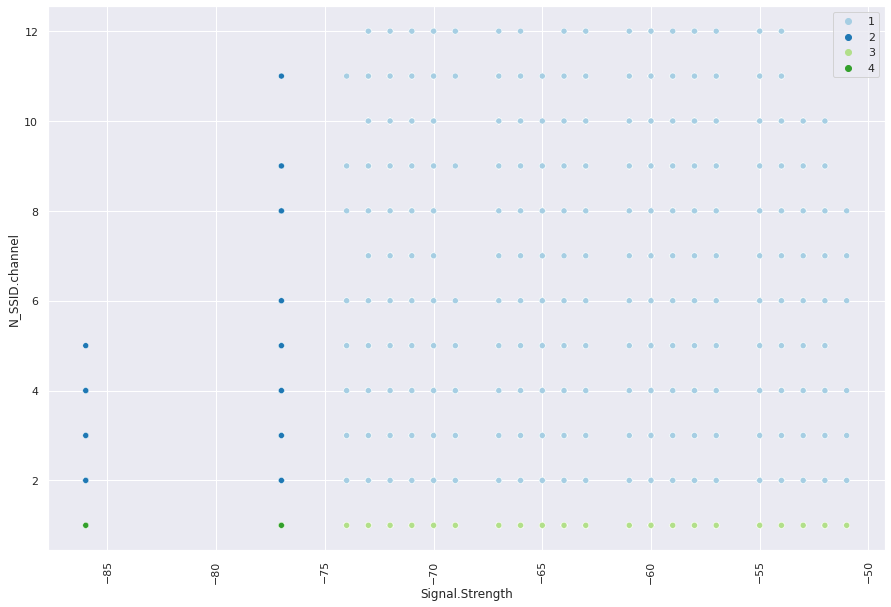

In [ ]:
# Gráfico de la cantidad de SSID vs la intensidad de la señal. Se puede visualizar el color de cada tipo de canal
sns.set(rc={"figure.figsize":(15, 10)})
g = sns.scatterplot(x='Signal.Strength', y='N_SSID.channel', hue='Desicion.cambio', data=df, palette='Paired')
g.tick_params(axis='x', rotation=90)
plt.legend(loc='upper right')

## Gráfico del Numero de SSID y la intensidad de la señal, con las desiciones a tomar para el día: 2018-04-15

Notar que solo se encuentran los problemas 1, 2, 3

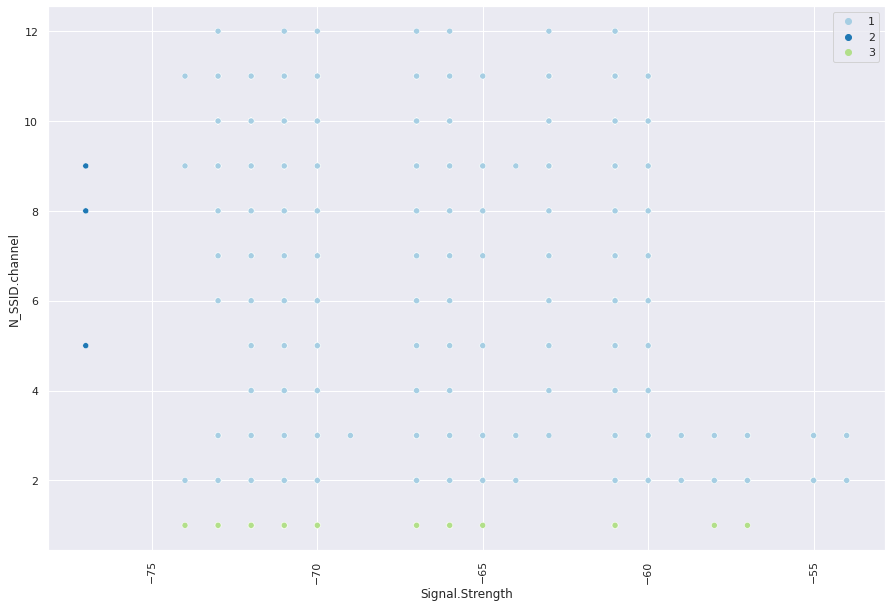

In [ ]:
# Gráfico de la cantidad de SSID vs la intensidad de la señal y y la desición de cambio en un día
sns.set(rc={"figure.figsize":(15, 10)})
g = sns.scatterplot(x='Signal.Strength', y='N_SSID.channel', hue='Desicion.cambio', data=df[df['Date'] == '2018-04-15'], palette='Paired')
g.tick_params(axis='x', rotation=90)
plt.legend(loc='upper right')

## Gráfico con la cantidad de SSID y la intensidad de señal, con los canales, en el día con mas muestras de datos para el día: 2018-04-15.

En este sentido, podría funcionar sin inconvenientes en el canal: 2, 3, 4, 5, 7, 8, 9, 10. Siempre y cuando se cumplan las reglas de ortogonalidad de las señales.

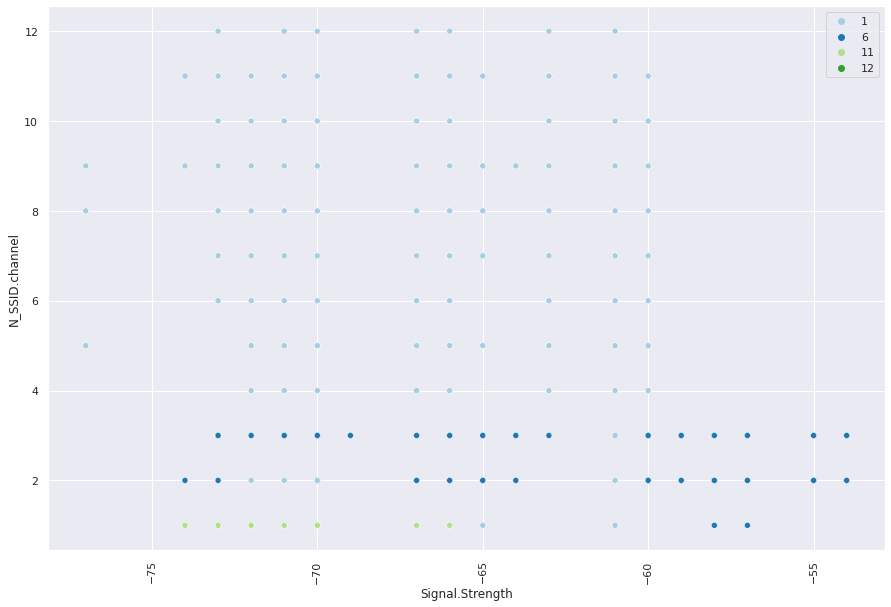

In [ ]:
# Gráfico de la cantidad de SSID vs la intensidad de la señal y los segmantos de canales en un día determinado
sns.set(rc={"figure.figsize":(15, 10)})
g = sns.scatterplot(x='Signal.Strength', y='N_SSID.channel', hue='Channel', data=df[df['Date'] == '2018-04-15'], palette='Paired')
g.tick_params(axis='x', rotation=90)
plt.legend(loc='upper right')

Se realizó una clasificacion del canal sin resultados positivos, la simulación demoró horas.

# KNN

## División de datos conjuntos de entrenamiento y de test

In [ ]:
df.head(2)

,Date,Time,SSID,N_Channel.ssid,Channel,N_SSID.channel,Hour,MAC.Address,Signal.Strength,Survey,High.SSID,High.Signal,Desicion.cambio
0,2018-03-07,17:07:08,AndroidAP2029,1,4,1,17,1C:23:2C:D1:0F:41,-67,1,0,1,3
1,2018-03-07,17:07:08,AndroidAP6485,1,8,1,17,DC:66:72:F8:BF:1F,-58,1,0,1,3


In [ ]:
X = df.iloc[:, [8, 5]].values
y = df.iloc[:, 12].values

In [ ]:
X

array([[-67,   1],
       [-58,   1],
       [-65,   2],
       ...,
       [-61,   5],
       [-72,   2],
       [-61,   5]])

In [ ]:
print(X.shape)
print(y.shape)

(356337, 2)
(356337,)


In [ ]:
# Dividir el data set en conjunto de entrenamiento y conjunto de testing
# Para este caso: 20 para entrenar y 10 elementos para test.
# de los 10 elementos: Uno de cada 3 individuos para test: 1/4*40 = 10
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [ ]:
# Escalado de variables
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [ ]:
# Ajustar el clasificador en el Conjunto de Entrenamiento
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = "minkowski", p = 2)
classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
# Predicción de los resultados con el Conjunto de Testing
y_pred  = classifier.predict(X_test)

/usr/local/lib/python3.8/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


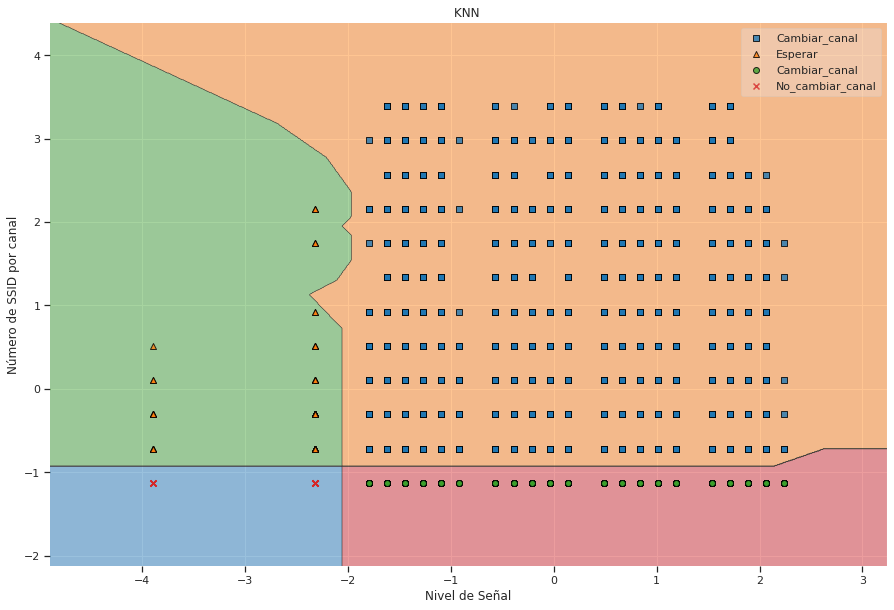

In [ ]:
# Grafico con normalización
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt
from sklearn.svm import SVC

# Plotting decision regions
ax=plot_decision_regions(X_train, y_train, clf=classifier, legend=2)

# Adding axes annotations
plt.title('KNN ')
plt.xlabel('Nivel de Señal')
plt.ylabel('Número de SSID por canal')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, 
          ['Cambiar_canal', 'Esperar', 'Cambiar_canal', 'No_cambiar_canal'], 
           framealpha=0.3, scatterpoints=1)

plt.show()

/usr/local/lib/python3.8/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


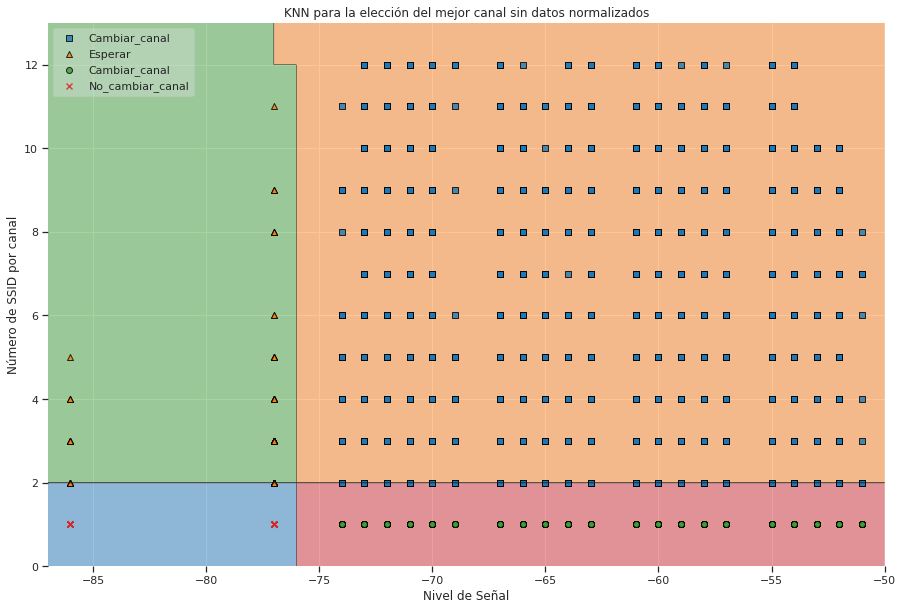

In [ ]:
# Grafico sin normalización para visualizar los datos del nivel de señal
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

# Training a classifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = "minkowski", p = 2)
classifier.fit(X, y)

# Plotting decision regions
ax=plot_decision_regions(X, y, clf=classifier, legend=2)

# Adding axes annotations
plt.title('KNN para la elección del mejor canal sin datos normalizados')
plt.xlabel('Nivel de Señal')
plt.ylabel('Número de SSID por canal')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, 
          ['Cambiar_canal', 'Esperar', 'Cambiar_canal', 'No_cambiar_canal'], 
           framealpha=0.3, scatterpoints=1)

plt.show()

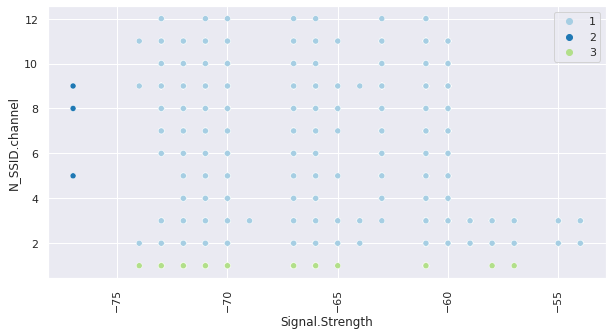

In [ ]:
# Gráfico de la cantidad de SSID en un canal vs la intensidad de la señal en el día con mas capturas de datos
sns.set(rc={"figure.figsize":(10, 5)})
g = sns.scatterplot(x='Signal.Strength', y='N_SSID.channel', hue='Desicion.cambio', data=df[df['Date'] == '2018-04-15'], palette='Paired')
g.tick_params(axis='x', rotation=90)
plt.legend(loc='upper right')

In [ ]:
# Elaborar una matriz de confusión
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[61683     0     0     0]
 [    1    15     0     0]
 [    0     0  9568     0]
 [    0     0     0     1]]


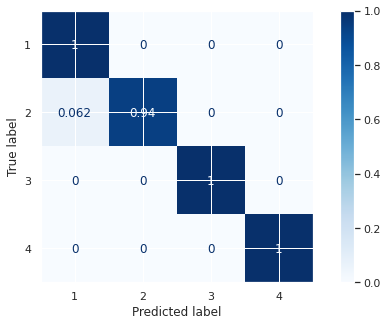

In [ ]:
from sklearn.metrics.pairwise import normalize
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, X_test, y_test, cmap = plt.cm.Blues, normalize = 'true')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00     61683
           2       1.00      0.94      0.97        16
           3       1.00      1.00      1.00      9568
           4       1.00      1.00      1.00         1

    accuracy                           1.00     71268
   macro avg       1.00      0.98      0.99     71268
weighted avg       1.00      1.00      1.00     71268



Se tiene una presición del 100% en todas las clases, esto puede ser causa de un overfitting. Pero se considera debido a que los datos se encuentran organizados de tal forma que se clasifican perfectamente. Aqui lo que estamos buscando es clasificar en 4 tipos de problemas.

En este caso se clasificaron como 4 tipos de canales

* Canal sin muchos AP y sin altos niveles de señal presentes = 4 (Condición ideal, no cambiar de canal)
  * Canal sin muchos AP y con altos niveles de señal presentes = 3 (Cambiar a otro canal, porque puede haber otros canales sin altos niveles de señal presentes)
  * Canal con muchos AP y sin altos niveles de señal presentes = 2 (Aceptable, esperar)
  * Canal con muchos AP y con alto nivel de señal = 1 (cambiar de canal)

# LSTM:

Finalmente, en base a las ideas de los papers que corresponden a la implementación de MAchine Learning y Deep Learning en los sistemas inalámbricos como el WIFI, se ha tomado la idea de tiempo de ocupación de un canal en la banda de 2,4GHZ. Este canal corresponde al canal 6, el mismo se usará para predecir su uso en el tiempo y de esta forma sugerir estrategias de diseño e implementación de una red WIFI.

In [ ]:
# Visualizar el dataset para el proceso de creación del modelo.
df.head(2)

,Date,Time,SSID,N_Channel.ssid,Channel,N_SSID.channel,Hour,MAC.Address,Signal.Strength,Survey,High.SSID,High.Signal,Desicion.cambio
0,2018-03-07,17:07:08,AndroidAP2029,1,4,1,17,1C:23:2C:D1:0F:41,-67,1,0,1,3
1,2018-03-07,17:07:08,AndroidAP6485,1,8,1,17,DC:66:72:F8:BF:1F,-58,1,0,1,3


## Análisis de la temporalidad de la cantidad de SSID por canal en un día: 2018-03-08.

In [ ]:
# Se filtra en un día específico
df1 = df[df['Date']=='2018-03-08']
df1.head(2)

,Date,Time,SSID,N_Channel.ssid,Channel,N_SSID.channel,Hour,MAC.Address,Signal.Strength,Survey,High.SSID,High.Signal,Desicion.cambio
1711,2018-03-08,00:00:29,DIRECT-zV-BCNIMP016,1,6,2,0,2A:24:FF:79:D5:BC,-60,1,1,1,1
1712,2018-03-08,00:00:29,DIRECT-zV-BCNIMP017,1,6,2,0,2A:24:FF:74:F9:D8,-57,1,1,1,1


In [ ]:
# Agrupar por Día, hora y canal para ver la cantidad de SSID en un canal se determina el promedio del uso del canal por la cantidad de SSID presentes
df2 = df1.groupby(['Date', 'Hour', 'Channel']).agg({'N_SSID.channel' : 'mean'}).reset_index()
df2.head(10)

,Date,Hour,Channel,N_SSID.channel
0,2018-03-08,0,1,2.229508
1,2018-03-08,0,6,2.196850
2,2018-03-08,0,11,1.000000
3,2018-03-08,0,12,1.000000
4,2018-03-08,1,1,2.269841
5,2018-03-08,1,6,2.168000
6,2018-03-08,1,11,1.000000
7,2018-03-08,1,12,1.000000
8,2018-03-08,2,1,2.120690
9,2018-03-08,2,6,2.165354


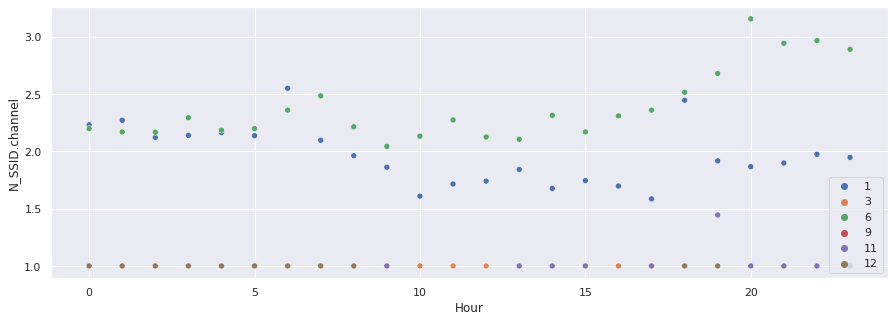

In [ ]:
# Gráfico del canal versus un Día (Horas) (TIEMPO DE OCUPACIÓN DEL CANAL EN UN DÍA)
sns.set(rc={"figure.figsize":(15, 5)})
g = sns.scatterplot(x='Hour', y='N_SSID.channel', hue='Channel', data=df2, palette="deep")
g.tick_params(axis='x', rotation=0)
plt.legend(loc='lower right')

## Creación de la red neuronal recurrente para precedir la cantidad de SSID en el canal 6

In [ ]:
# Agrupar por Día, hora y canal para ver la cantidad de SSID en un canal se determina el promedio del uso del canal por la cantidad de SSID presentes
df3 = df.groupby(['Date', 'Channel']).agg({'N_SSID.channel' : 'mean'}).reset_index()
df3.head(10)

,Date,Channel,N_SSID.channel
0,2018-03-07,1,1.968276
1,2018-03-07,4,1.000000
2,2018-03-07,6,2.192220
3,2018-03-07,8,1.000000
4,2018-03-07,11,1.800000
5,2018-03-07,12,1.000000
6,2018-03-08,1,2.015781
7,2018-03-08,3,1.000000
8,2018-03-08,6,2.421679
9,2018-03-08,9,1.000000


In [ ]:
df3.shape

(226, 3)

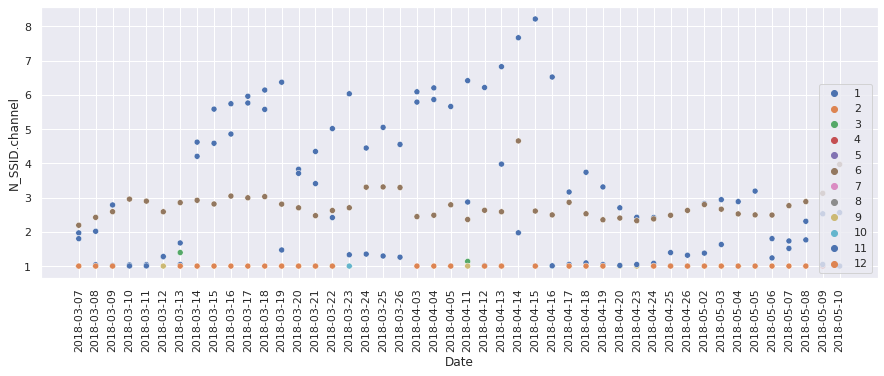

In [ ]:
# Gráfico de la cantidad de SSID por canal versus el Día (TIEMPO DE OCUPACIÓN)
sns.set(rc={"figure.figsize":(15, 5)})
g = sns.scatterplot(x='Date', y='N_SSID.channel', hue='Channel', data=df3, palette="deep")
g.tick_params(axis='x', rotation=90)
plt.legend(loc='lower right')

In [ ]:
# Filtro de los datos del canal 6.
df4 = df3[df3['Channel']== 6].reset_index()
df4 = df4.drop('index', axis = 1)
df4.head(10)

,Date,Channel,N_SSID.channel
0,2018-03-07,6,2.192220
1,2018-03-08,6,2.421679
2,2018-03-09,6,2.587629
3,2018-03-10,6,2.955272
4,2018-03-11,6,2.896241
5,2018-03-12,6,2.585879
6,2018-03-13,6,2.853130
7,2018-03-14,6,2.920423
8,2018-03-15,6,2.812742
9,2018-03-16,6,3.044628


In [ ]:
df4.shape

(46, 3)

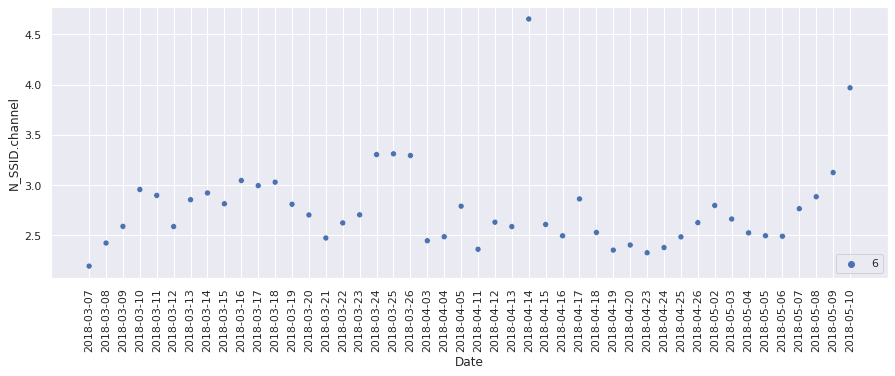

In [ ]:
# Gráfico del canal versus un Día (TIEMPO DE OCUPACIÓN DEL CANAL EN UN DÍA) canal 6
sns.set(rc={"figure.figsize":(15, 5)})
g = sns.scatterplot(x='Date', y='N_SSID.channel', hue='Channel', data=df4, palette="deep")
g.tick_params(axis='x', rotation=90)
plt.legend(loc='lower right')

In [ ]:
# Los datos de entrada, se los pasa a una matriz con numpy
training_set = df4.iloc[:, 2:3].values
training_set.shape

(46, 1)

In [ ]:
# Tratamiento de los datos temporales
x_time = df4.iloc[:, 0] # extraigo la columna de tiempo
x_time1= x_time.to_list() #Conversión a lista
x_time1

['2018-03-07',
 '2018-03-08',
 '2018-03-09',
 '2018-03-10',
 '2018-03-11',
 '2018-03-12',
 '2018-03-13',
 '2018-03-14',
 '2018-03-15',
 '2018-03-16',
 '2018-03-17',
 '2018-03-18',
 '2018-03-19',
 '2018-03-20',
 '2018-03-21',
 '2018-03-22',
 '2018-03-23',
 '2018-03-24',
 '2018-03-25',
 '2018-03-26',
 '2018-04-03',
 '2018-04-04',
 '2018-04-05',
 '2018-04-11',
 '2018-04-12',
 '2018-04-13',
 '2018-04-14',
 '2018-04-15',
 '2018-04-16',
 '2018-04-17',
 '2018-04-18',
 '2018-04-19',
 '2018-04-20',
 '2018-04-23',
 '2018-04-24',
 '2018-04-25',
 '2018-04-26',
 '2018-05-02',
 '2018-05-03',
 '2018-05-04',
 '2018-05-05',
 '2018-05-06',
 '2018-05-07',
 '2018-05-08',
 '2018-05-09',
 '2018-05-10']

In [ ]:
# En este punto, lo que se intenta es normalizar los datos
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [ ]:
# Crear una estructura de datos con 60 timesteps 60 dias atras y 1 salida
X_train = []
y_train = []
for i in range(10, 46):
    X_train.append(training_set_scaled[i-10:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
# Visualizar la dimesión de la variable temporal
X_train.shape

(36, 10)

In [ ]:
# Redimensión de los datos
# 1 es la variable predictora
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
X_train.shape

(36, 10, 1)

In [ ]:
# Librerías para la Construcción de la red LSTM
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [ ]:
# Inicialización del modelo
regressor = Sequential()

# Añadir la primera capa de LSTM y la regulariación por Dropout
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1) ))
regressor.add(Dropout(0.2))

# Añadir la segunda capa de LSTM y la regulariación por Dropout
regressor.add(LSTM(units = 50, return_sequences = True ))
regressor.add(Dropout(0.2))

# Añadir la tercera capa de LSTM y la regulariación por Dropout
regressor.add(LSTM(units = 50, return_sequences = True ))
regressor.add(Dropout(0.2))

# Añadir la cuarta capa de LSTM y la regulariación por Dropout
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Añadir la capa de salida
regressor.add(Dense(units = 1))

# Compilar la RNR
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])

# Ajustar la RNR al conjunto de entrenamiento
regressor.fit(X_train, y_train, epochs = 800, batch_size = 32)

Epoch 1/800
2/2 [==============================] - 7s 14ms/step - loss: 0.0923 - accuracy: 0.0000e+00
Epoch 2/800
2/2 [==============================] - 0s 12ms/step - loss: 0.0742 - accuracy: 0.0000e+00
Epoch 3/800
2/2 [==============================] - 0s 11ms/step - loss: 0.0600 - accuracy: 0.0000e+00
Epoch 4/800
2/2 [==============================] - 0s 12ms/step - loss: 0.0437 - accuracy: 0.0000e+00
Epoch 5/800
2/2 [==============================] - 0s 11ms/step - loss: 0.0388 - accuracy: 0.0000e+00
Epoch 6/800
2/2 [==============================] - 0s 11ms/step - loss: 0.0453 - accuracy: 0.0000e+00
Epoch 7/800
2/2 [==============================] - 0s 11ms/step - loss: 0.0374 - accuracy: 0.0000e+00
Epoch 8/800
2/2 [==============================] - 0s 12ms/step - loss: 0.0334 - accuracy: 0.0000e+00
Epoch 9/800
2/2 [==============================] - 0s 12ms/step - loss: 0.0386 - accuracy: 0.0000e+00
Epoch 10/800
2/2 [==============================] - 0s 12ms/step - loss: 0.0402 - 

In [ ]:
# Obtener el valores reales
dataset_test = df4
real_df4 = dataset_test.iloc[:, 2:3].values
len(real_df4)

46

In [ ]:
# Obtener la predicción de la cantidad de canales
dataset_total = pd.concat((df4['N_SSID.channel'], dataset_test['N_SSID.channel']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 10:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(10, 40):
    X_test.append(inputs[i-10:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_SSIDperchannel = regressor.predict(X_test)
predicted_SSIDperchannel = sc.inverse_transform(predicted_SSIDperchannel)


1/1 [==============================] - 2s 2s/step


In [ ]:
len(predicted_SSIDperchannel)

30

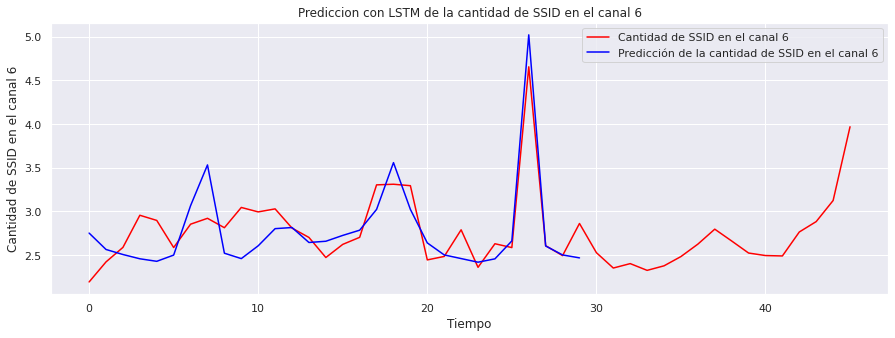

In [ ]:
# Visualizar los Resultados

plt.plot(real_df4, color = 'red', label = 'Cantidad de SSID en el canal 6')
plt.plot(predicted_SSIDperchannel, color = 'blue', label = 'Predicción de la cantidad de SSID en el canal 6')

plt.title("Prediccion con LSTM de la cantidad de SSID en el canal 6")
plt.xlabel("Tiempo")
plt.ylabel("Cantidad de SSID en el canal 6")
plt.legend()
plt.show()

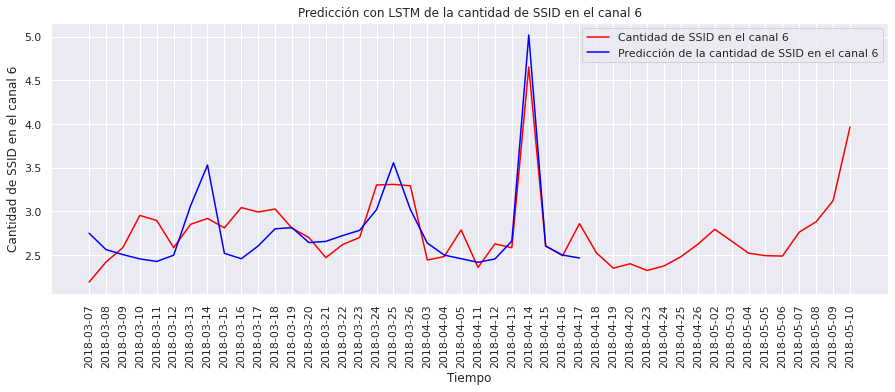

In [ ]:
#Visualizar los Resultados
#Se agregan las listas x1 y x2 de acuerdo a la dimensión de los array que bota el dataset real y la predicción.
x1 = list(range(1,47))
x2 = list(range(1,31))
plt.plot(x1, real_df4, color = 'red', label = 'Cantidad de SSID en el canal 6')
plt.plot(x2, predicted_SSIDperchannel, color = 'blue', label = 'Predicción de la cantidad de SSID en el canal 6')
plt.xticks(x, x_time1, rotation='vertical')
plt.title("Predicción con LSTM de la cantidad de SSID en el canal 6")
plt.xlabel("Tiempo")
plt.ylabel("Cantidad de SSID en el canal 6")
plt.legend()

plt.show()

# CONCLUSIONES:

* El dataset escogido, se lo ha usado debido a la facilidad de captura de los datos, de tal forma que el experimento sea replicado de forma práctica en cualquier lugar.

* De acuerdo a las ideas sugeridas, con clasificación KNN, se podría establecer el canal de trabajo WIFI, de igual manera con LSTM se podría predecir que fecha a futuro se tendrá mayor cantidad de SSID en cualquier canal. De esta forma obtener estrategias al momento del diseño de la red y estrategias de mantenimiento a futuro para re-ubicar puntos de acceso, cambiar su tecnología o re-configurar el canal.

* Se requiere mas datos para realizar una predicción adecuada, para el caso de LSTM.

* Al ser un primer proyecto de estas características, se puede observar que las tecnologías de MAchine Learning y Deep Learning, son herramientas potentes para la solución de varios problemas en tecnología.

# BIBLIOGRAFÍA:

* Szott, S., Kosek-Szott, K., Gawłowicz, P., Gómez, J. T., Bellalta, B., Zubow, A., & Dressler, F. (2022). Wi-Fi Meets ML: A Survey on Improving IEEE 802.11 Performance With Machine Learning. IEEE Communications Surveys & Tutorials, 24(3), 1843-1893. https://doi.org/10.1109/COMST.2022.3179242
* Géron, A. (2019). Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems (second). O’Reilly. https://www.amazon.com/-/es/Aur%C3%A9lienG%C3%A9ron/dp/1492032646/ref=sr_1_4?__mk_es_US=%C3%85M%C3%85%C5%BD%C3%95%C3%91&crid=15XVFCGFZ8NNX&keywords=hands+on+machine+learning+with+scikitlearn+and+tensorflow&qid=1674513353&sprefix=hands+on+machine+learning+with+scikit-learn+and+tensorflow%2Caps%2C150&sr=8-4

* Raschka, S., & Mirjalili, V. (2019). Python Machine Learning—Third Edition (Tercera). Packt.

* De La Sierra, J. (2018). Office occupancy using WiFi signals. Kaggle.
https://kaggle.com/code/jmartindelasierra/office-occupancy-using-wifi-signals